# COLLEGE UPWARD MOBILITY

Every year journalists and economists (USA today, the Wall Street journal, Forbes etc.) rank the best undergraduate colleges in the USA. While the top colleges are associated with good employment outcomes, they are expensive, highly selective and largely exclusive. For the majority of students in America, attending college is a means to increase economic mobility, that is, to be able earn more than a high school student. For many of these students attending top tier ivy leagues is not an option because of tuition costs, family income and their SAT scores. The primary goal of this initiative is to develop a predictive model that can help low-income students decide where to go to college to increase their economic mobility. 

## ------------------------------------------------------------------
## Importing and cleaning the data from College Scorecard
## ------------------------------------------------------------------

In [2]:
import pandas as pd
import json
import urllib2
from pandas.io.json import json_normalize
import re
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm


In [3]:
# I imported (~45) variables of interest to the csv file from the data dictionatry provided by College score card
# https://collegescorecard.ed.gov/data/documentation/

Allvariables = pd.read_csv('allVariables.csv')

# convert df to a list of variables in the format required by the API query
#API query format is year.category.developer-friendly name
#format year.category.developer-friendly name 

#adding a . to category
Allvariables['dev-category'] = Allvariables['dev-category'].astype(str) +'.' 

#variables that are associated with the school and don't change with year 
school_variables = Allvariables[Allvariables['dev-category'].isin(['school.'])]

#variables that change with year
year_variables = Allvariables[~Allvariables['dev-category'].isin(['school.'])]

#concatenating category and developer-friendly name and converting it to a list
year_var_name = list(year_variables[['dev-category','developer-friendly name']].astype(str).sum(axis=1))
school_var_name = list(school_variables[['dev-category','developer-friendly name']].astype(str).sum(axis=1))
#remove the root variable
year_var_name.remove('root.id')
year_var_name.remove('root.ope8_id')
year_var_name.remove('root.ope6_id')

In [4]:
# Reading the academic variables separately
# https://collegescorecard.ed.gov/data/documentation/

Academics = pd.read_csv('academics.csv')

# convert df to a list of variables in the format required by the API query
#API query format is year.category.developer-friendly name
#format year.category.developer-friendly name 

#adding a . to category
Academics['dev-category'] = Academics['dev-category'].astype(str) +'.' 

#concatenating category and developer-friendly name and converting it to a list
academic_var_name = list(Academics[['dev-category','developer-friendly name']].astype(str).sum(axis=1))


In [5]:
#Only download all the  data from the api if not already downloaded 
#once downloaded the data is saved as a csv format

if os.path.exists("year_data.csv"):
    allyears_df = pd.read_csv("year_data.csv")
    print("Year data already extracted from API")
else:   
    # for data that changes by year, loop through the years and download all the data
    #number of years
    years = range(1997,2016)
    years.remove(2011) 
    #number of pages per year
    n = int(7593/100)+1 #number of total entries per year / number of enteries per page: 100 is the max. 
    #empty list of data frames for all the data
    alldata =[]
    for year in years:
        #build the query from var_name
        QueryAPI= str(year)+'.'+(','+str(year)+'.').join(year_var_name)
        #create empty list to store all page dfs for a year 
        allpages =[]
        print "Downloading year {}".format(year)
        #loop to get all pages (n) for a year (API only allows a max of 100 enteries per page)
        for i in xrange(0, n):
            try:
                print "Downloading Page {}".format(i)
                api ='https://api.data.gov/ed/collegescorecard/v1/schools?fields=school.name,id,{}&_per_page=100&page={}&api_key=7EfsgcFY3JfMxQJ7tAW0Cjqamb77iOHPbpdBXTP6'.format(QueryAPI, str(i))
                req = urllib2.Request(api)
                response = urllib2.urlopen(req)
                response_read = response.read()
                json_data=json.loads(response_read)
                #store the results of each api call (pages) to a data frame
                df = json_normalize(json_data, 'results', meta = 'metadata')
                #removing the year from the column title so that we can concatenate columns across all years
                replace = str(year)+'.' 
                df.columns=[re.sub(replace,'', s) for s in df.columns] 
                #make a list of dataframes
                allpages.append(df)
            except:
                pass  
        #combine all df in the list to a single df per year    
        all_pages_df = pd.concat(allpages)
        #add a year column
        all_pages_df['year'] =year
        #store all dfs per year in a list 
        alldata.append(all_pages_df)
    #combine all df in the list to a single df for all years     
    allyears_df = pd.concat(alldata)
    #write the df to a csv file
    allyears_df.to_csv('year_data.csv')
 

Year data already extracted from API


In [6]:
if os.path.exists("school_data.csv"):
    allschools_df = pd.read_csv("school_data.csv")
    print("School data already extracted from API")
else:
    n = int(7593/100)+1 #number of total entries per year / number of enteries per page: 100 is the max. 
    #empty list of data frames for all the data
    alldata =[]
    QueryAPI= (',').join(school_var_name)
    #loop to get all pages (n) (API only allows a max of 100 enteries per page)
    for i in xrange(0, n):
        try:
            print "Downloading Page {}".format(i)
            api ='https://api.data.gov/ed/collegescorecard/v1/schools?fields=school.name,id,ope8_id,ope6_id,school.region_id,location.lat,location.lon,{}&_per_page=100&page={}&api_key=7EfsgcFY3JfMxQJ7tAW0Cjqamb77iOHPbpdBXTP6'.format(QueryAPI, str(i))
            req = urllib2.Request(api)
            response = urllib2.urlopen(req)
            response_read = response.read()
            json_data=json.loads(response_read)
            #store the results of each api call (pages) to a data frame
            df = json_normalize(json_data, 'results', meta = 'metadata')
            #removing the year from the column title so that we can concatenate columns across all years
            replace = str(year)+'.' 
            df.columns=[re.sub(replace,'', s) for s in df.columns] 
            #make a list of dataframes
            alldata.append(df)
        except:
            pass  
    #combine all df in the list to a single df for all years     
    allschools_df = pd.concat(alldata)
    #write the df to a csv file
    allschools_df.to_csv('school_data.csv')
 

School data already extracted from API


In [7]:
#Only download all the  data from the api if not already downloaded 
#once downloaded the data is saved as a csv format

if os.path.exists("academic_data.csv"):
    allyears_academic_df = pd.read_csv("academic_data.csv")
    print("Academic data already extracted from API")
else:   
    # for data that changes by year, loop through the years and download all the data
    #number of years
    years = range(1997,2016)
    years.remove(2007)
    #years.remove(2013)
    #number of pages per year
    n = int(7593/100)+1 #number of total entries per year / number of enteries per page: 100 is the max. 
    #empty list of data frames for all the data
    alldata =[]
    for year in years:
        #build the query from var_name
        QueryAPI= str(year)+'.'+(','+str(year)+'.').join(academic_var_name)
        #create empty list to store all page dfs for a year 
        allpages =[]
        print "Downloading year {}".format(year)
        #loop to get all pages (n) for a year (API only allows a max of 100 enteries per page)
        for i in xrange(0, n):
            try:
                print "Downloading Page {}".format(i)
                api ='https://api.data.gov/ed/collegescorecard/v1/schools?fields=school.name,id,{}&_per_page=100&page={}&api_key=7EfsgcFY3JfMxQJ7tAW0Cjqamb77iOHPbpdBXTP6'.format(QueryAPI, str(i))
                req = urllib2.Request(api)
                response = urllib2.urlopen(req)
                response_read = response.read()
                json_data=json.loads(response_read)
                #store the results of each api call (pages) to a data frame
                df = json_normalize(json_data, 'results', meta = 'metadata')
                #removing the year from the column title so that we can concatenate columns across all years
                replace = str(year)+'.' 
                df.columns=[re.sub(replace,'', s) for s in df.columns] 
                #make a list of dataframes
                allpages.append(df)
            except:
                pass
        try:
            #combine all df in the list to a single df per year    
            all_pages_df = pd.concat(allpages)
            #add a year column
            all_pages_df['year'] =year
            #store all dfs per year in a list 
            alldata.append(all_pages_df)
        except:
            pass
    #combine all df in the list to a single df for all years     
    allyears_academic_df = pd.concat(alldata)
    #write the df to a csv file
    allyears_academic_df.to_csv('academic_data.csv')
 

Academic data already extracted from API


In [8]:
### download state data 
n = int(7593/100)+1
if os.path.exists("states.csv"):
    state_df = pd.read_csv("states.csv")
    print("State data already extracted from API")
else: 
    alldata=[]
    for i in xrange(0, n):
        try:
            print "Downloading Page {}".format(i)
            api ='https://api.data.gov/ed/collegescorecard/v1/schools?fields=school.name,id,school.state&_per_page=100&page={}&api_key=7EfsgcFY3JfMxQJ7tAW0Cjqamb77iOHPbpdBXTP6'.format(str(i))
            req = urllib2.Request(api)
            response = urllib2.urlopen(req)
            response_read = response.read()
            json_data=json.loads(response_read)
            #store the results of each api call (pages) to a data frame
            df = json_normalize(json_data, 'results', meta = 'metadata')
            #make a list of dataframes
            alldata.append(df)
        except:
            pass  

    # combine all df in the list to a single df for all years     
    state_df = pd.concat(alldata)
    state_df.to_csv('states.csv')

State data already extracted from API


## Missing data

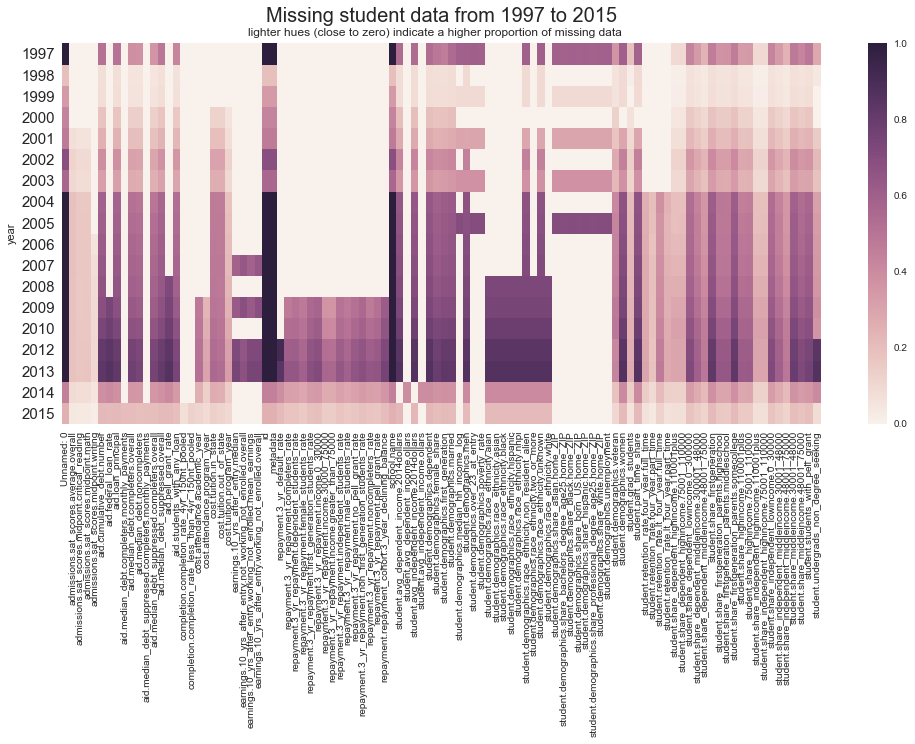

In [30]:
%matplotlib inline 
missing = allyears_df.groupby('year').count()
missing = missing/7593 #dividing it by the total to get a proportion.
plt.figure(figsize=(17,7))
plt.xticks(fontsize=10)
plt.yticks(fontsize=15)
plt.title("Missing student data from 1997 to 2015", fontsize=20, ha='center', x=0.5, y=1.04)
plt.suptitle('lighter hues (close to zero) indicate a higher proportion of missing data', fontsize=12, ha='center', x=0.43, y=0.91)
sns.heatmap(missing)
plt.show()## Missing data


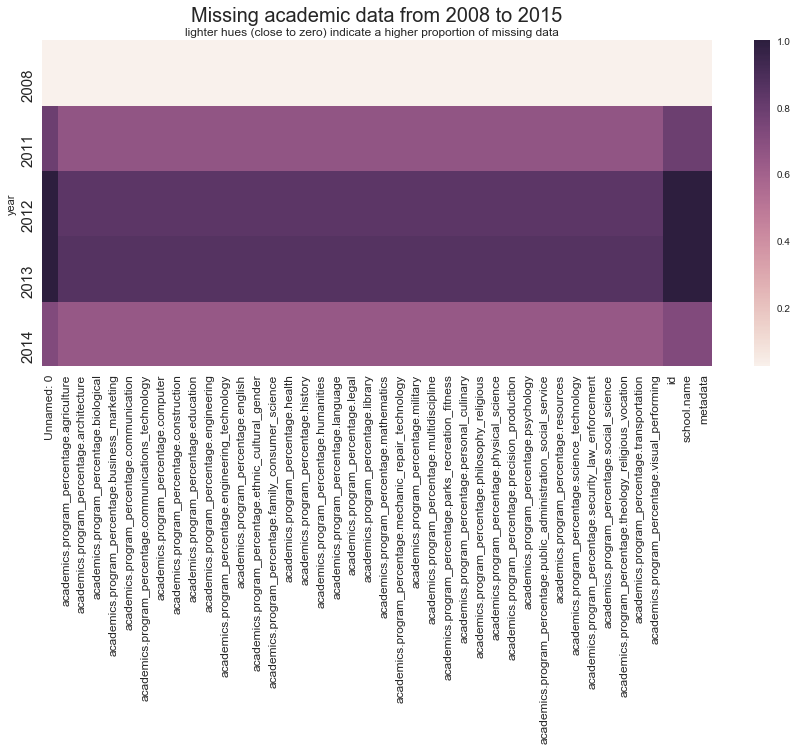

In [31]:
%matplotlib inline 
missing = allyears_academic_df.groupby('year').count()
missing = missing/7593 #dividing it by the total to get a proportion.
plt.figure(figsize=(15,6))
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.title("Missing academic data from 2008 to 2015", fontsize=20, ha='center', x=0.5, y=1.04)
plt.suptitle('lighter hues (close to zero) indicate a higher proportion of missing data', fontsize=12, ha='center', x=0.43, y=0.91)
sns.heatmap(missing)
plt.show()## Missing data

### The college scorecard data is missing for a number of field in many years. Since 2013 is the most comprehensive data collection year. I will focus on the data collected in 2013. The most recent year of census data is available for 2005. I will impute the 2013 data with census data from 2005 .  

In [32]:
#replace blank values (coded as -3) with NAs
allschools_df=allschools_df.replace(-3.0, np.NaN)

## Carnegie classifications for colleges 

In [33]:
#All these classifications were coded using integers with associated categorical data provided in the data dictionary. 
#Here I change the integers to classifications using the dictionary (imported as a csv)
## Carnegie school type classification
## Using the data dictionary 
carnegie = pd.read_csv('Carnegie_notations.csv', header=None)
carnegie_dict =dict(carnegie.values)
allschools_df["school.carnegie_basic"].replace(carnegie_dict, inplace=True)
#print(allschools_df["school.carnegie_basic"].value_counts(dropna=False))
# almost a thrid of the colleges are not classified 

In [34]:
## Carnegie undergrad classification
carnegie_ug = pd.read_csv('Carnegie_undergrad.csv', header=None)
carnegie_ug_dict =dict(carnegie_ug.values)
allschools_df["school.carnegie_undergrad"].replace(carnegie_ug_dict, inplace=True)
#print(allschools_df["school.carnegie_undergrad"].value_counts(dropna=False))
# almost a thrid of the colleges are not classified 
#remove all the graduate professional only colleges and two-year colleges

In [35]:
## Carnegie size classification
carnegie_sz = pd.read_csv('Carnegie_size.csv', header=None)
carnegie_sz_dict =dict(carnegie_sz.values)
allschools_df["school.carnegie_size_setting"].replace(carnegie_sz_dict, inplace=True)
#print(allschools_df["school.carnegie_size_setting"].value_counts(dropna=False))
# almost a thrid of the colleges are not classified 

In [36]:
##  regional classification
region = pd.read_csv('regionID.csv', header=None)
region_dict =dict(region.values)
allschools_df["school.region_id"].replace(region_dict, inplace=True)
#print(allschools_df["school.region_id"].value_counts(dropna=False))

In [37]:
# this columnn is non-existant so remove from df 
allschools_df.drop('school.degree_urbanization', axis=1, inplace=True)

In [38]:
## Locale classification
locale = pd.read_csv('urbanization.csv', header=None)
locale_dict =dict(locale.values)
allschools_df["school.locale"].replace(locale_dict, inplace=True)

#print(allschools_df["school.locale"].value_counts(dropna=False))
# almost a thrid of the colleges are not classified 

###  The college scorecard data has median family income and income post graduation but these are median values across all students. To get an idea of the students who come from lower income families and climb the economic ladder, I am using data from the http://www.equality-of-opportunity.org/ project which has caluclated metric of mobility using non-identified tax information from individuals. 

### The metrics they calculate are: 

- Median parent household income (par_median)
- Median child individual earnings in 2014 (rounded to the nearest 100 dollars) (k_median)
- Fraction of parents in the Bottom 20% of the income distribution (par_q1)
- Fraction of parents in the Top 1% of the income distribution (par_top1pc)
- Percent of children who reach the Top 20% of the income distribution among children with parents in the Bottom 20% of the income distribution (kq5_cond_parq1)
- Percent of children who reach the Top 1% of the income distribution among children with parents in the Bottom 20% of the income distribution (ktop1pc_cond_parq1)
- Percent of students who have parents in the Bottom 20% of the income distribution and reach the Top 20% of the income distribution (Mobility Rate)
- Upper-Tail Mobility Rate: Percent of students who have parents in the Bottom 20% of the income distribution and reach the Top 1% of the income distribution
- Change in % of Parents from the Bottom 20% of the income distribution between the 1980 and 1991 cohorts (trend_parq1)
- Change in % of Parents from the Bottom 40% of the income distribution between the 1980 and 1991 cohorts (trend_bottom40: )

## Merging datasets

In [39]:
### Merging state data with school data -- downloaded separately
allschools_df_state=pd.merge(allschools_df, state_df[['id','school.state']], left_on='id', right_on='id', how ='inner')

In [40]:
### Merging school data with mobility data from the equal opportunity project
mobility_EOP = pd.read_csv("http://www.equality-of-opportunity.org/data/college/mrc_table1.csv")
#combing dataframes by either names or id -- neither is consistant amongst the two dataframes
allschools_EOP_df= pd.merge(allschools_df_state, mobility_EOP, left_on='super_opeid', right_on='super_opeid')

In [41]:
#merge all_schools with the 2013 data for schools
# 2013 most complete dataset 
df_2013 = allyears_df[(allyears_df['year']==2013)] 
#impute missing census data in 2013 from 2005
df_2005 = allyears_df[(allyears_df['year']==2005)]
#impute census columns
impute_cols = ['student.demographics.share_white.home_ZIP', \
'student.demographics.share_black.home_ZIP', \
'student.demographics.share_asian.home_ZIP', \
'student.demographics.share_hispanic.home_ZIP', \
'student.demographics.share_bachelors_degree_age25.home_ZIP', \
'student.demographics.share_professional_degree_age25.home_ZIP', \
'student.demographics.share_born_US.home_ZIP', \
'student.demographics.poverty_rate', \
'student.demographics.unemployment', \
'student.demographics.median_hh_income_log']
# selecting the census columns from 2005
df_2005_cenus = df_2005[impute_cols]
df_2005_cenus['id'] = df_2005['id']

# removing the census columns from 2013
df_2013.drop(impute_cols, axis=1, inplace=True)

# merging the 2013 dataset with the 2015 census data on id
df_2013_imputed = pd.merge(df_2013, df_2005_cenus, left_on='id', right_on='id')

/Users/taniajogesh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taniajogesh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
#main dataset
df_2013_full = pd.merge(df_2013_imputed, allschools_EOP_df, left_on='id', right_on='id')

### Renaming columns to more intuitive names

In [43]:
colnames = pd.read_csv('colnames.csv')
colnames_dict = dict(zip(colnames['old'], colnames['new']))
df_2013_full.rename(columns=colnames_dict, inplace=True)

### Calculating indicies

In [44]:
#minority_serving
df_2013_full['minority_serving']= \
df_2013_full['minority_serving_hispanic']+ \
df_2013_full['minority_serving_predominantly_black']+ \
df_2013_full['minority_serving_historically_black']+ \
df_2013_full['minority_serving_tribal']+ \
df_2013_full['minority_serving_aanipi']+ \
df_2013_full['minority_serving_annh']
#df_2013_full['minority_serving'][df_2013_full.minority_serving>1]=1

# % underrep moniorities  
df_2013_full['underrep_minorities'] = \
df_2013_full['prop_black'] +\
df_2013_full['prop_hispanic'] + \
df_2013_full['prop_pacific_islander'] + \
df_2013_full['prop_native_american'] \

#calculate how much more students earn on average after attending the college
df_2013_full['debt_income_ratio'] = \
df_2013_full['median_debt_completers_overall']/df_2013_full['median_earnings_in_10_yrs']

# % underrep moniorities in neighbourhood  
df_2013_full['underrep_minorities_census'] = \
df_2013_full['prop_black_homes_in_neighborhood'] +\
df_2013_full['prop_hispanic_homes_in_neighborhood'] 



## ----------------------------------
## Exploratory Data Aanalysis 
## ----------------------------------

## Check normality and outliers in the data with histograms

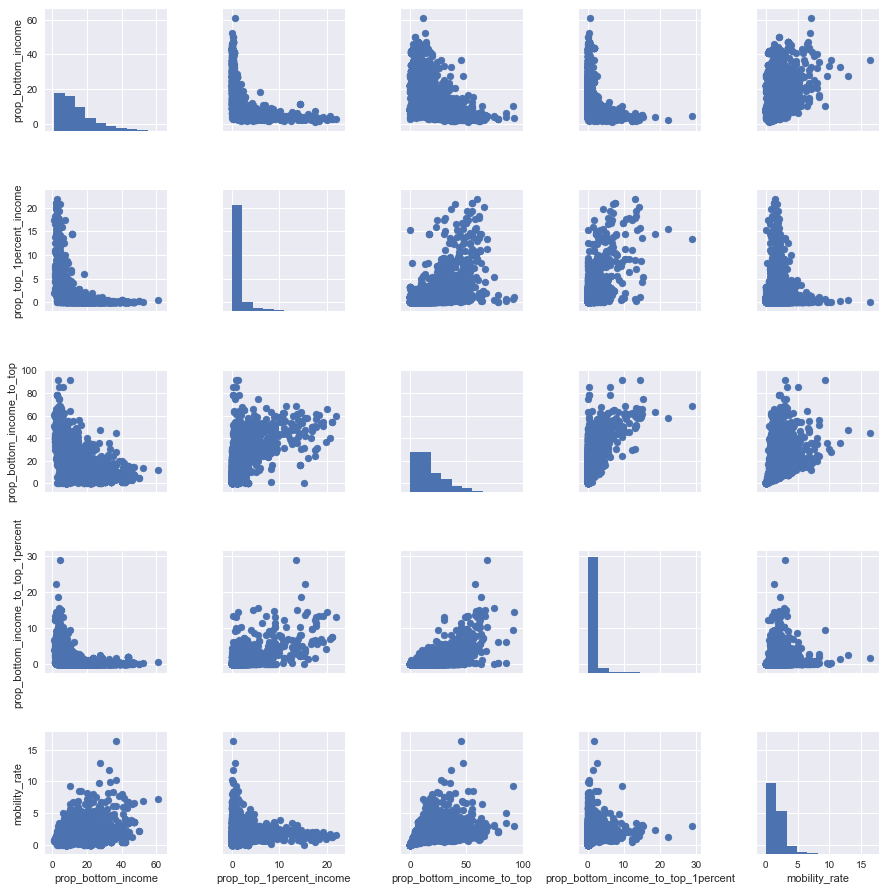

In [23]:
data = df_2013_full[['prop_bottom_income',
                     'prop_top_1percent_income',
                     'prop_bottom_income_to_top',
                     'prop_bottom_income_to_top_1percent',
                     'mobility_rate']]
data_sqrt=np.sqrt(data)
g = sns.PairGrid(data)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
plt.show()

#### All of these are non-normal with a bias towards lower values. A sqrt transformation should approximate a normal distribution 

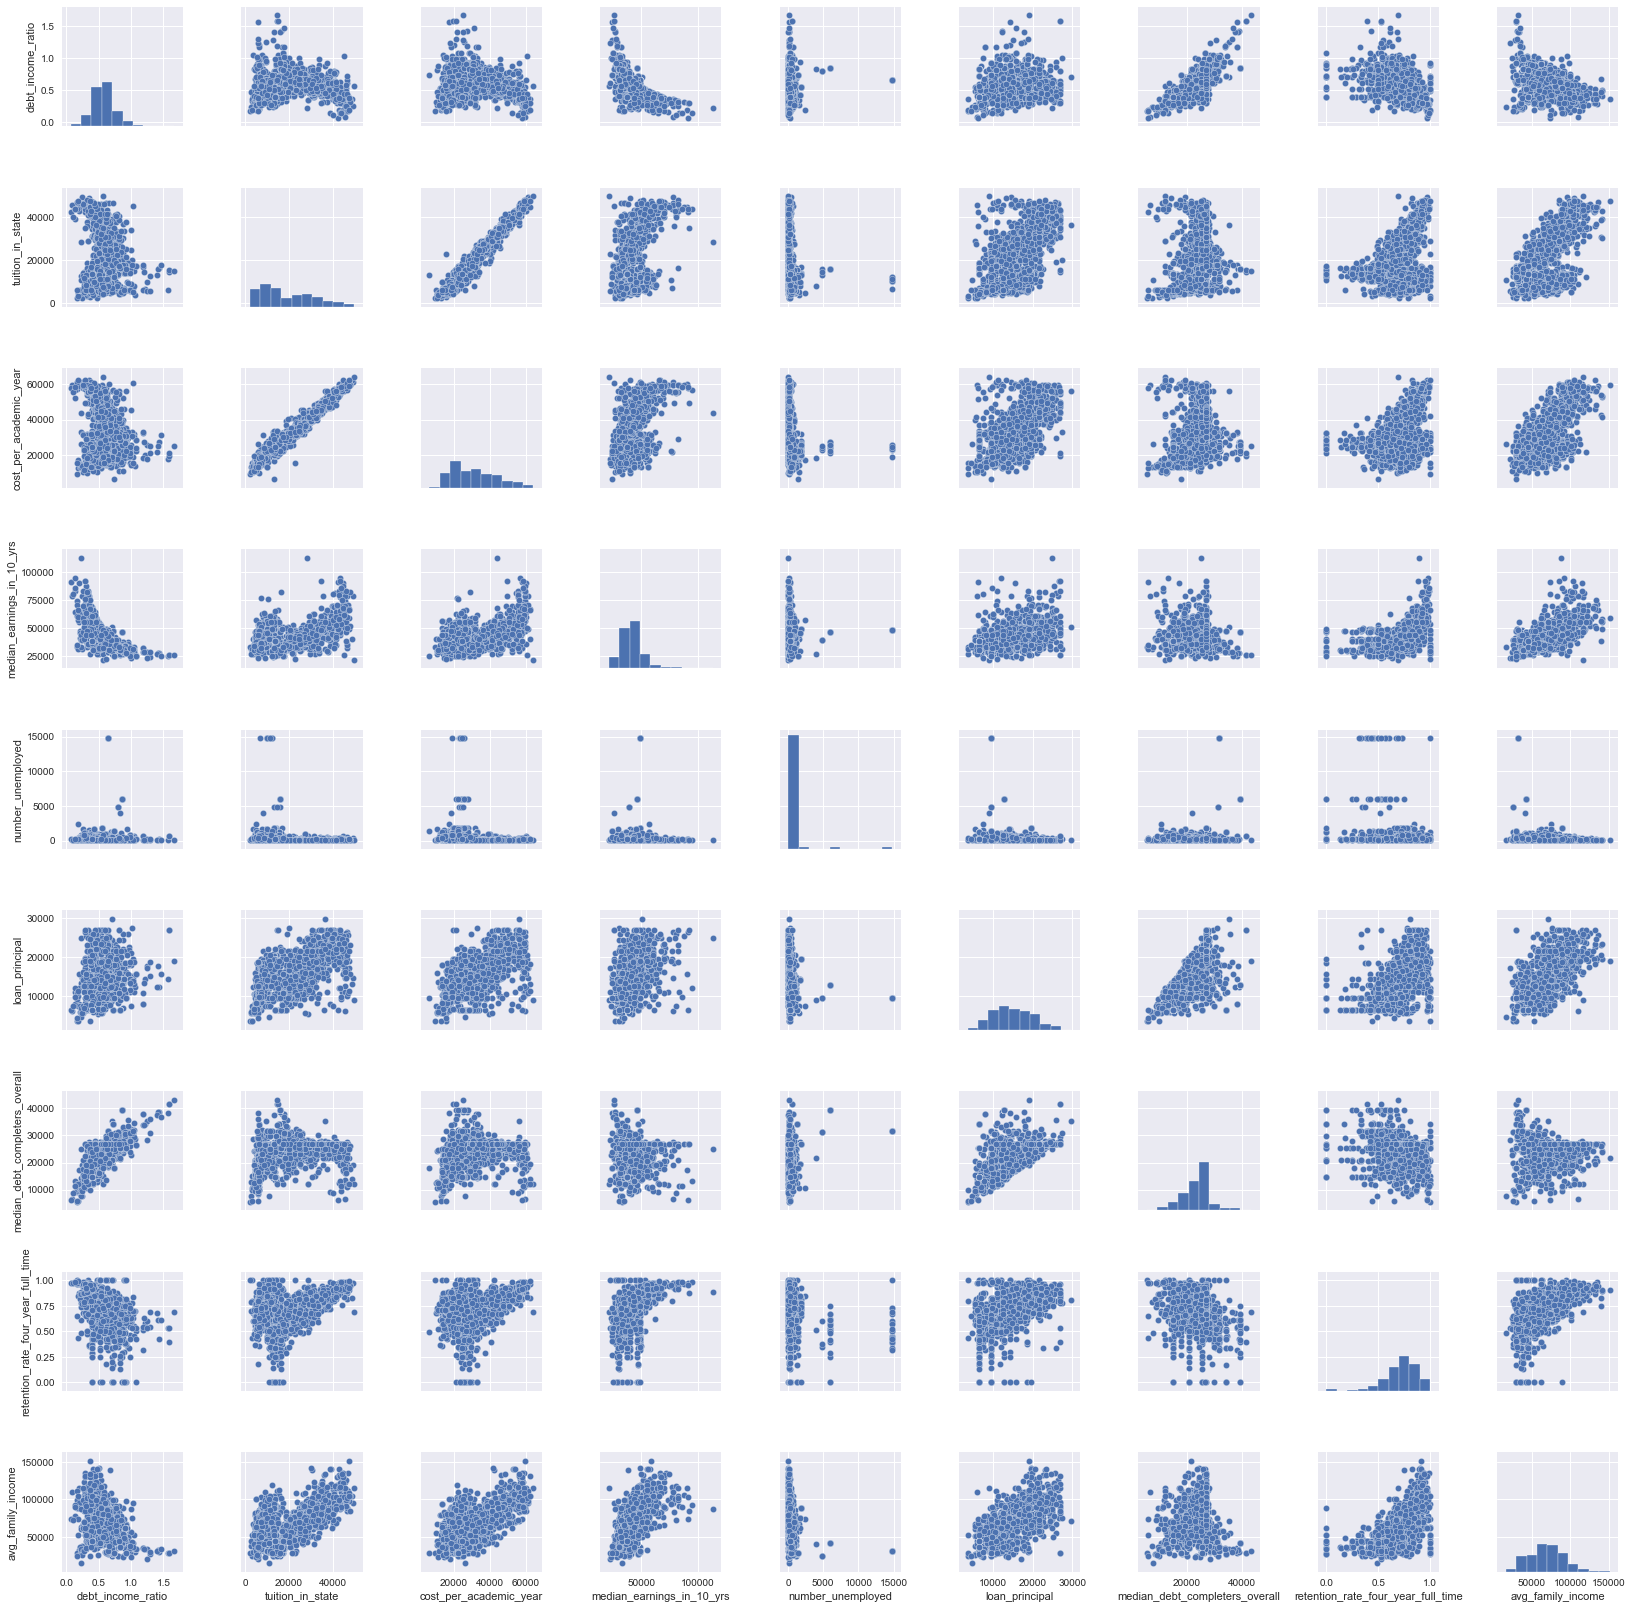

In [24]:
data = df_2013_full[['debt_income_ratio',
                     'tuition_in_state',
                     'cost_per_academic_year',
                     'median_earnings_in_10_yrs',
                     'number_unemployed',
                     'loan_principal',
                     'median_debt_completers_overall',
                     'retention_rate_four_year_full_time',
                     'avg_family_income']].dropna()
                     

g = sns.PairGrid(data)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)
#data['debt_income_ratio']

#### Tuition is bimodal, cost per academic year is a better metric of cost.  The number unemployed has high values for some universities.  

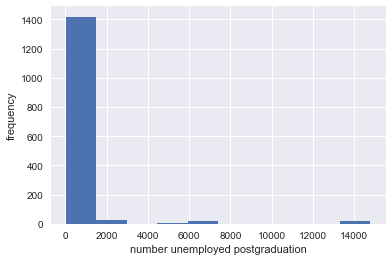

In [25]:
data['number_unemployed'].hist()
plt.xlabel('number unemployed postgraduation')
plt.ylabel('frequency')
plt.show()            

In [26]:
df_2013_full[df_2013_full.number_unemployed >4000][['school_name','number_unemployed']].head(10)

school_name  number_unemployed
33               DeVry University-Arizona             6005.0
34            DeVry University-California             6005.0
35              DeVry University-Illinois             6005.0
36              DeVry University-Michigan             6005.0
37                DeVry University-Nevada             6005.0
38                  DeVry University-Ohio             6005.0
39                 DeVry University-Texas             6005.0
40              DeVry University-Virginia             6005.0
161   University of Phoenix-Washington DC            14774.0
173  University of Phoenix-South Carolina            14774.0

#### University of Phoenix and DeVry are the outliers contributing to this! These are both online, large universities with minimal selectivity and pending lawsuits for poor educational quality. These data points are not really outliers but indicative of these institutions. 

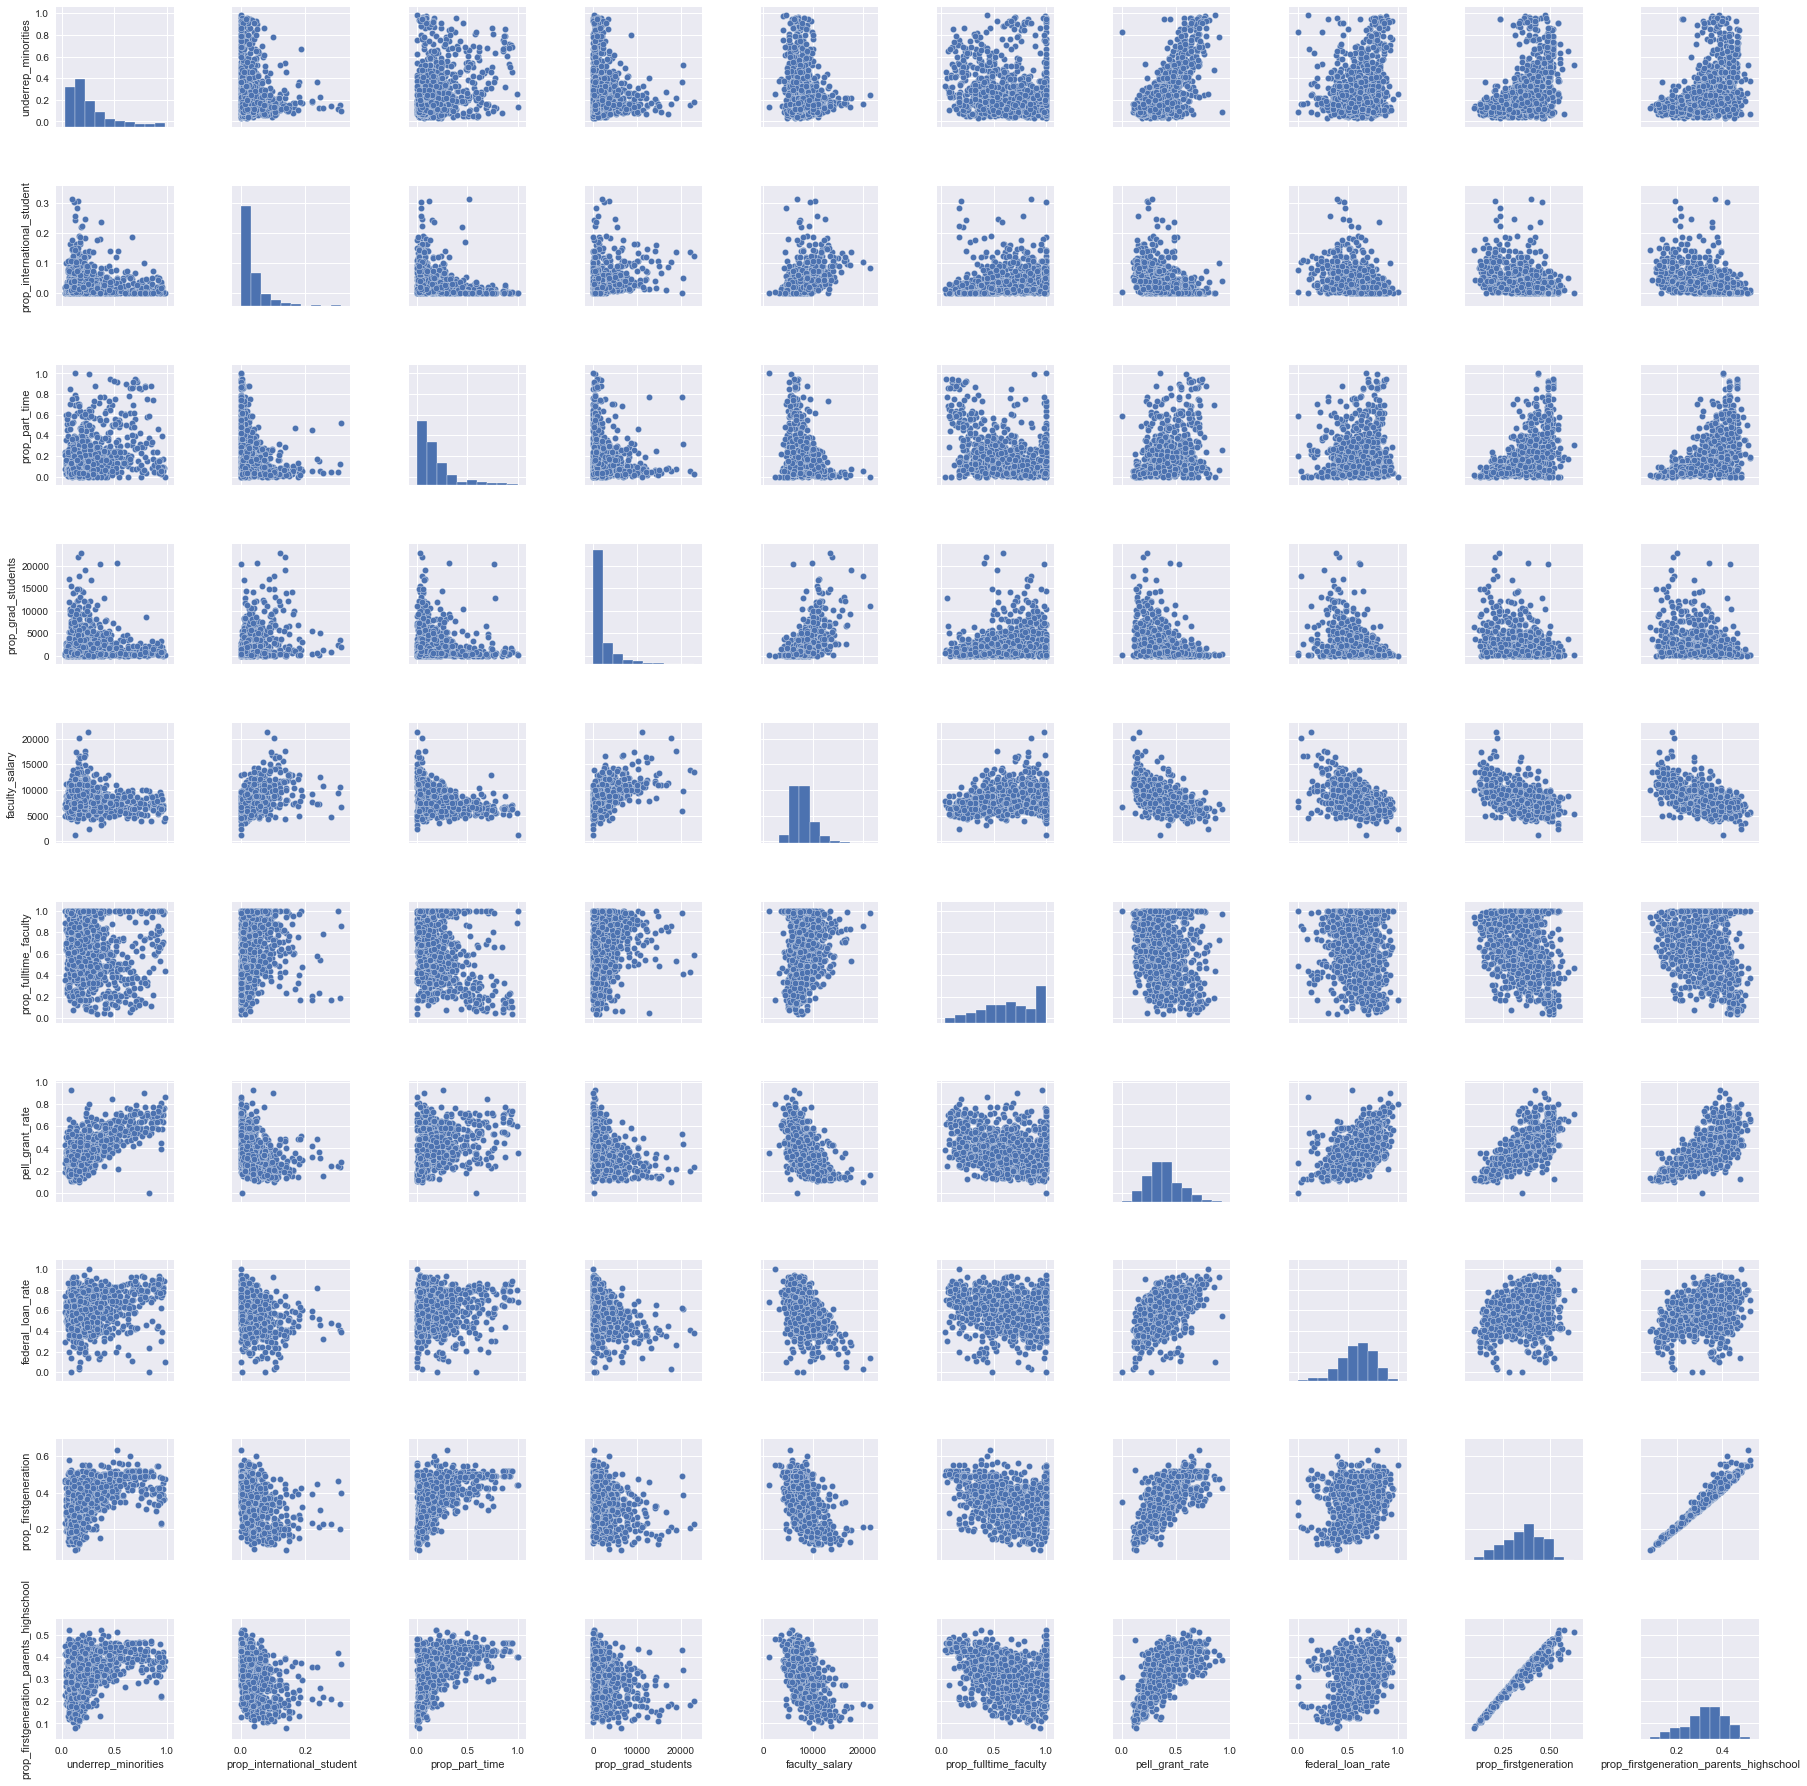

In [27]:
data = df_2013_full[['underrep_minorities',
                     'prop_international_student',
                     'prop_part_time',
                     'prop_grad_students',
                     'faculty_salary',
                     'prop_fulltime_faculty',
                     'pell_grant_rate',
                     'federal_loan_rate',
                     'prop_firstgeneration',
                     'prop_firstgeneration_parents_highschool',
                    ]].dropna()
g = sns.PairGrid(data)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

#### proportion of minorities, international students and grad students is not normal and biased towards lower proportions. A large number of institutions have all full time faculty, making this proportion also non-normal.  Proportion data often do not conform to a normal distribution and are often arcsine square root transformed or analyzed with other distributions (e.g. binomial).  No obvious outliers here. 

In [29]:
## some values appear to be close to 0 but doesn't look like there are any salaries below $1000. 
## these are probably real and not mistakes in the data
df_2013_full[df_2013_full.faculty_salary <2000][['name_broad','faculty_salary']].head(10)

name_broad  faculty_salary
1478      Ottawa University          1257.0
1862  University Of Phoenix          1641.0

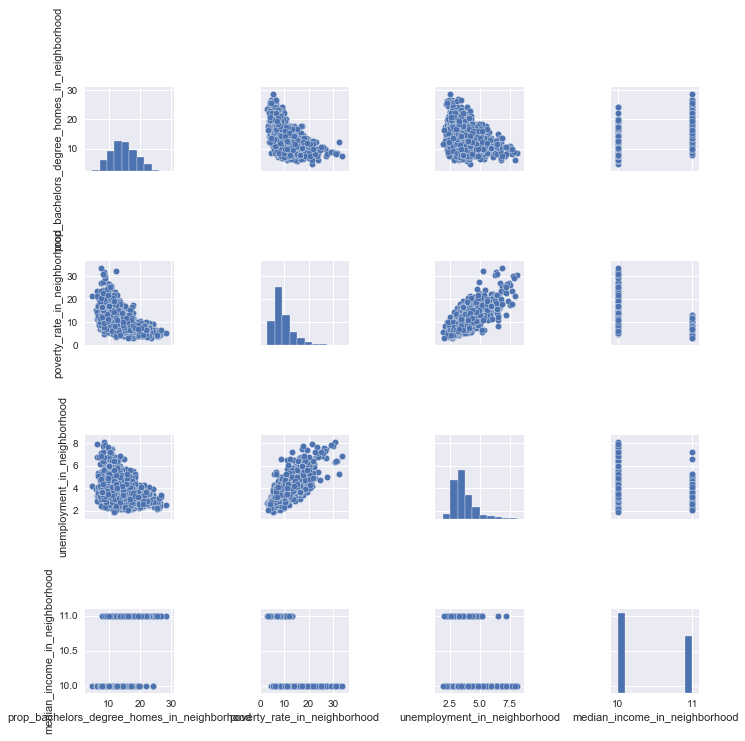

In [30]:
data = df_2013_full[['prop_bachelors_degree_homes_in_neighborhood',
                     'poverty_rate_in_neighborhood',
                     'unemployment_in_neighborhood',
                     'median_income_in_neighborhood'
                    ]].dropna()
g = sns.PairGrid(data)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

#### median_income_in_neighborhood is categorical. The data dictionary decribes this as continous. I'm not sure what 10 and 11 refer to here so I will refrain from using this. Everything else looks okay. 

## Visual trends in the data 

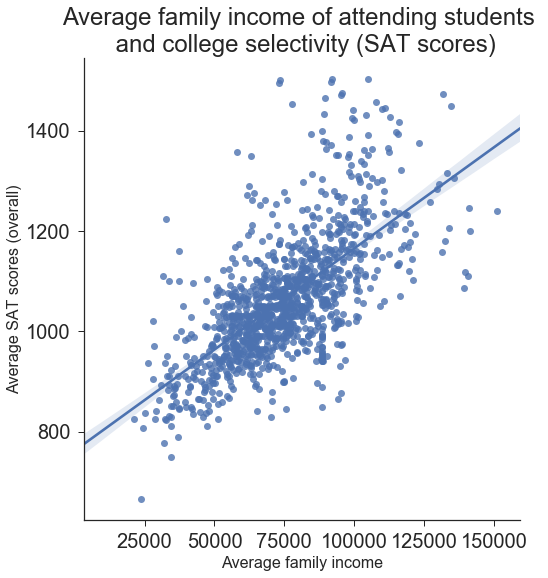

In [55]:
%matplotlib inline
sns.set(style="ticks", color_codes=True, font_scale=2 )
sns.lmplot(x="avg_family_income", y="sat_scores_average_overall", data=df_2013_full, size =8)
plt.title('Average family income of attending students \n and college selectivity (SAT scores)', fontsize = 24)
plt.xlabel('Average family income', fontsize = 16)
plt.ylabel('Average SAT scores (overall)', fontsize = 16)
plt.show()

### Selective schools admit a student body that is wealthy
What is remarkable, albiet not completely unexpected, is that schools that are more selective (those requiring higher SAT scores) generally admit a student body that is wealthy. Data on family income and SAT scores show that kids from poorer families tend do do worse on the SATs (https://economix.blogs.nytimes.com/2009/08/27/sat-scores-and-family-income/). What this means for upward mobility is that top tier, selective colleges, are not well-suited to increase the upward mobility of lower income families.   

In [85]:
## test for linear relationship
data = df_2013_full[['avg_family_income', 'sat_scores_average_overall']].dropna()
predictors = data['avg_family_income']
response = data['sat_scores_average_overall']
#predictors = sm.add_constant(predictors)
mod = sm.OLS(response, predictors)
res = mod.fit()
print(res.summary())

                                OLS Regression Results                                
Dep. Variable:     sat_scores_average_overall   R-squared:                       0.958
Model:                                    OLS   Adj. R-squared:                  0.958
Method:                         Least Squares   F-statistic:                 2.607e+04
Date:                        Wed, 13 Dec 2017   Prob (F-statistic):               0.00
Time:                                08:23:34   Log-Likelihood:                -7876.9
No. Observations:                        1156   AIC:                         1.576e+04
Df Residuals:                            1155   BIC:                         1.576e+04
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------

### A 10,000 dollar increase in family income increases SAT scores by on average 13.6 points and this relationship is statistically significant

### I ran regressions for all SAT scores so that missing scores can be imputed based on average family income at the college. This is important as a lot of SAT score data is missing from the dataset

In [47]:
## test for linear relationship math
data = df_2013_full[['avg_family_income', 'sat_scores_midpoint_math']].dropna()
predictors = data['avg_family_income']
response = data['sat_scores_midpoint_math']
#predictors = sm.add_constant(predictors)
mod = sm.OLS(response, predictors)
res = mod.fit()
print(res.summary())
## 380.9 + 0.002*family income

                               OLS Regression Results                               
Dep. Variable:     sat_scores_midpoint_math   R-squared:                       0.956
Model:                                  OLS   Adj. R-squared:                  0.956
Method:                       Least Squares   F-statistic:                 2.358e+04
Date:                      Thu, 14 Dec 2017   Prob (F-statistic):               0.00
Time:                              09:43:31   Log-Likelihood:                -6647.6
No. Observations:                      1082   AIC:                         1.330e+04
Df Residuals:                          1081   BIC:                         1.330e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------

In [87]:
## test for linear relationship writing 
data = df_2013_full[['avg_family_income', 'sat_scores_midpoint_writing']].dropna()
predictors = data['avg_family_income']
response = data['sat_scores_midpoint_writing']
#predictors = sm.add_constant(predictors)
mod = sm.OLS(response, predictors)
res = mod.fit()
print(res.summary())
## 348 + 0.0022*family income

                                 OLS Regression Results                                
Dep. Variable:     sat_scores_midpoint_writing   R-squared:                       0.961
Model:                                     OLS   Adj. R-squared:                  0.961
Method:                          Least Squares   F-statistic:                 1.565e+04
Date:                         Wed, 13 Dec 2017   Prob (F-statistic):               0.00
Time:                                 08:24:04   Log-Likelihood:                -3850.1
No. Observations:                          635   AIC:                             7702.
Df Residuals:                              634   BIC:                             7707.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------

In [88]:
## test for linear relationship - reading 
data = df_2013_full[['avg_family_income', 'sat_scores_midpoint_critical_reading']].dropna()
predictors = data['avg_family_income']
response = data['sat_scores_midpoint_critical_reading']
#predictors = sm.add_constant(predictors)
mod = sm.OLS(response, predictors)
res = mod.fit()
print(res.summary())
## 373.85 + 0.002*family income

                                     OLS Regression Results                                     
Dep. Variable:     sat_scores_midpoint_critical_reading   R-squared:                       0.957
Model:                                              OLS   Adj. R-squared:                  0.957
Method:                                   Least Squares   F-statistic:                 2.382e+04
Date:                                  Wed, 13 Dec 2017   Prob (F-statistic):               0.00
Time:                                          08:24:36   Log-Likelihood:                -6547.2
No. Observations:                                  1071   AIC:                         1.310e+04
Df Residuals:                                      1070   BIC:                         1.310e+04
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                        coef  

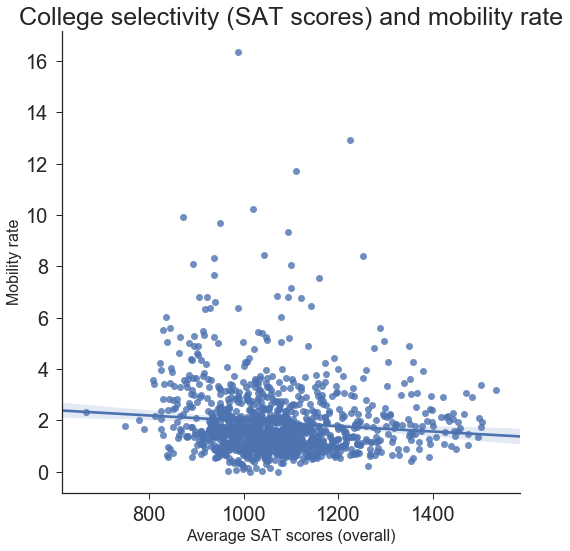

In [57]:
%matplotlib inline
sns.set(style="ticks", color_codes=True, font_scale=2 )
sns.lmplot(x="sat_scores_average_overall", y="mobility_rate", data=df_2013_full, size =8)
plt.title('College selectivity (SAT scores) and mobility rate', fontsize = 25)
plt.xlabel('Average SAT scores (overall)', fontsize = 16)
plt.ylabel('Mobility rate', fontsize = 16)
plt.show()

### College selectivity (SAT scores) have a small positive effect on mobility rate. i.e more selective colleges have marginally higher mobility. 

In [34]:
## test for linear relationships between these variables 
data = df_2013_full[['sat_scores_average_overall', 'mobility_rate']].dropna()
response = np.sqrt(data['mobility_rate'])
predictors = data['sat_scores_average_overall']
mod = sm.OLS(response, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          mobility_rate   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     9008.
Date:                Tue, 12 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:02:59   Log-Likelihood:                -796.81
No. Observations:                1191   AIC:                             1596.
Df Residuals:                    1190   BIC:                             1601.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
sat_scores_average_o

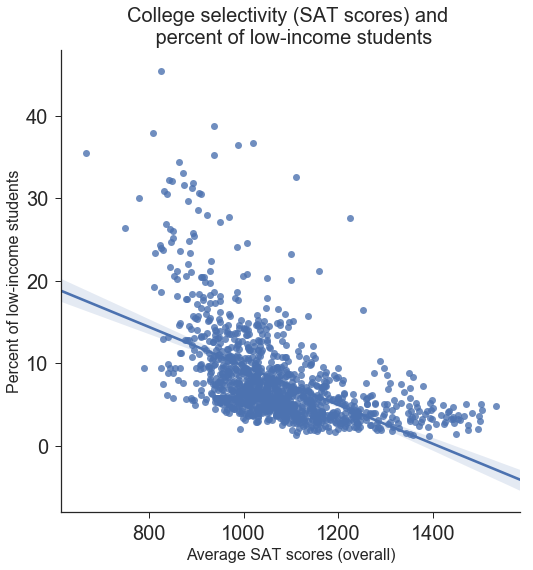

In [61]:
%matplotlib inline
sns.set(style="ticks", color_codes=True, font_scale=2 )
sns.lmplot(x="sat_scores_average_overall", y="prop_bottom_income", data=df_2013_full, size =8)
plt.title('College selectivity (SAT scores) and \n percent of low-income students', fontsize = 20)
plt.xlabel('Average SAT scores (overall)', fontsize = 16)
plt.ylabel('Percent of low-income students', fontsize = 16)
plt.show()

### selective colleges don't incease upward mobility because they not take in a high proportion of low income students 

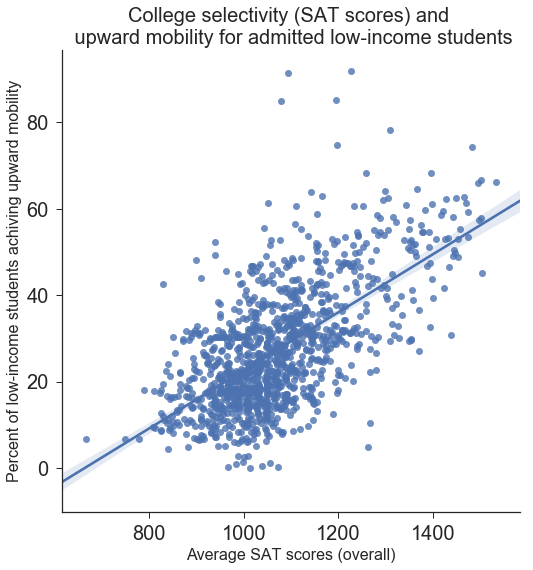

In [62]:
%matplotlib inline
sns.set(style="ticks", color_codes=True, font_scale=2 )
sns.lmplot(x="sat_scores_average_overall", y="prop_bottom_income_to_top", data=df_2013_full, size =8)
plt.title('College selectivity (SAT scores) and \n upward mobility for admitted low-income students', fontsize = 20)
plt.xlabel('Average SAT scores (overall)', fontsize = 16)
plt.ylabel('Percent of low-income students achiving upward mobility', fontsize = 16)
plt.show()

### However, for low income students who can get into more selective colleges, mobility is much higher. 

In [37]:
data = df_2013_full[['sat_scores_average_overall', 'prop_bottom_income_to_top']].dropna()
response = np.sqrt(data['prop_bottom_income_to_top'])
predictors = data['sat_scores_average_overall']
mod = sm.OLS(response, predictors)
res = mod.fit()
print(res.summary())

                                OLS Regression Results                               
Dep. Variable:     prop_bottom_income_to_top   R-squared:                       0.957
Model:                                   OLS   Adj. R-squared:                  0.957
Method:                        Least Squares   F-statistic:                 2.652e+04
Date:                       Tue, 12 Dec 2017   Prob (F-statistic):               0.00
Time:                               19:03:04   Log-Likelihood:                -1783.4
No. Observations:                       1191   AIC:                             3569.
Df Residuals:                           1190   BIC:                             3574.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------

### Correlation heatmap to look for important relationships. 

In [63]:
data = df_2013_full[['sat_scores_average_overall',
                     'prop_bottom_income',
                     'prop_top_1percent_income',
                     'prop_bottom_income_to_top',
                     'prop_bottom_income_to_top_1percent',
                     'mobility_rate',
                     'mobility_rate_to_top_1percent',
                     'debt_income_ratio',
                     'cost_per_academic_year',
                     'median_earnings_in_10_yrs',
                     'number_unemployed',
                     'loan_principal',
                     'median_debt_completers_overall',
                     'retention_rate_four_year_full_time',
                     'avg_family_income',
                     'underrep_minorities',
                     'prop_international_student',
                     'prop_part_time',
                     'prop_grad_students',
                     'faculty_salary',
                     'prop_fulltime_faculty',
                     'pell_grant_rate',
                     'federal_loan_rate',
                     'prop_firstgeneration',
                     'prop_firstgeneration_parents_highschool',
                     'prop_white_homes_in_neighborhood',
                     'underrep_minorities_census',
                     'prop_bachelors_degree_homes_in_neighborhood',
                     'poverty_rate_in_neighborhood',
                     'unemployment_in_neighborhood',
                     'median_income_in_neighborhood'
                    ]]

corr = data.corr()
corr.sort_values('sat_scores_average_overall', axis =1,inplace = True)
corr.sort_values('sat_scores_average_overall', axis =0, inplace = True, ascending = False)

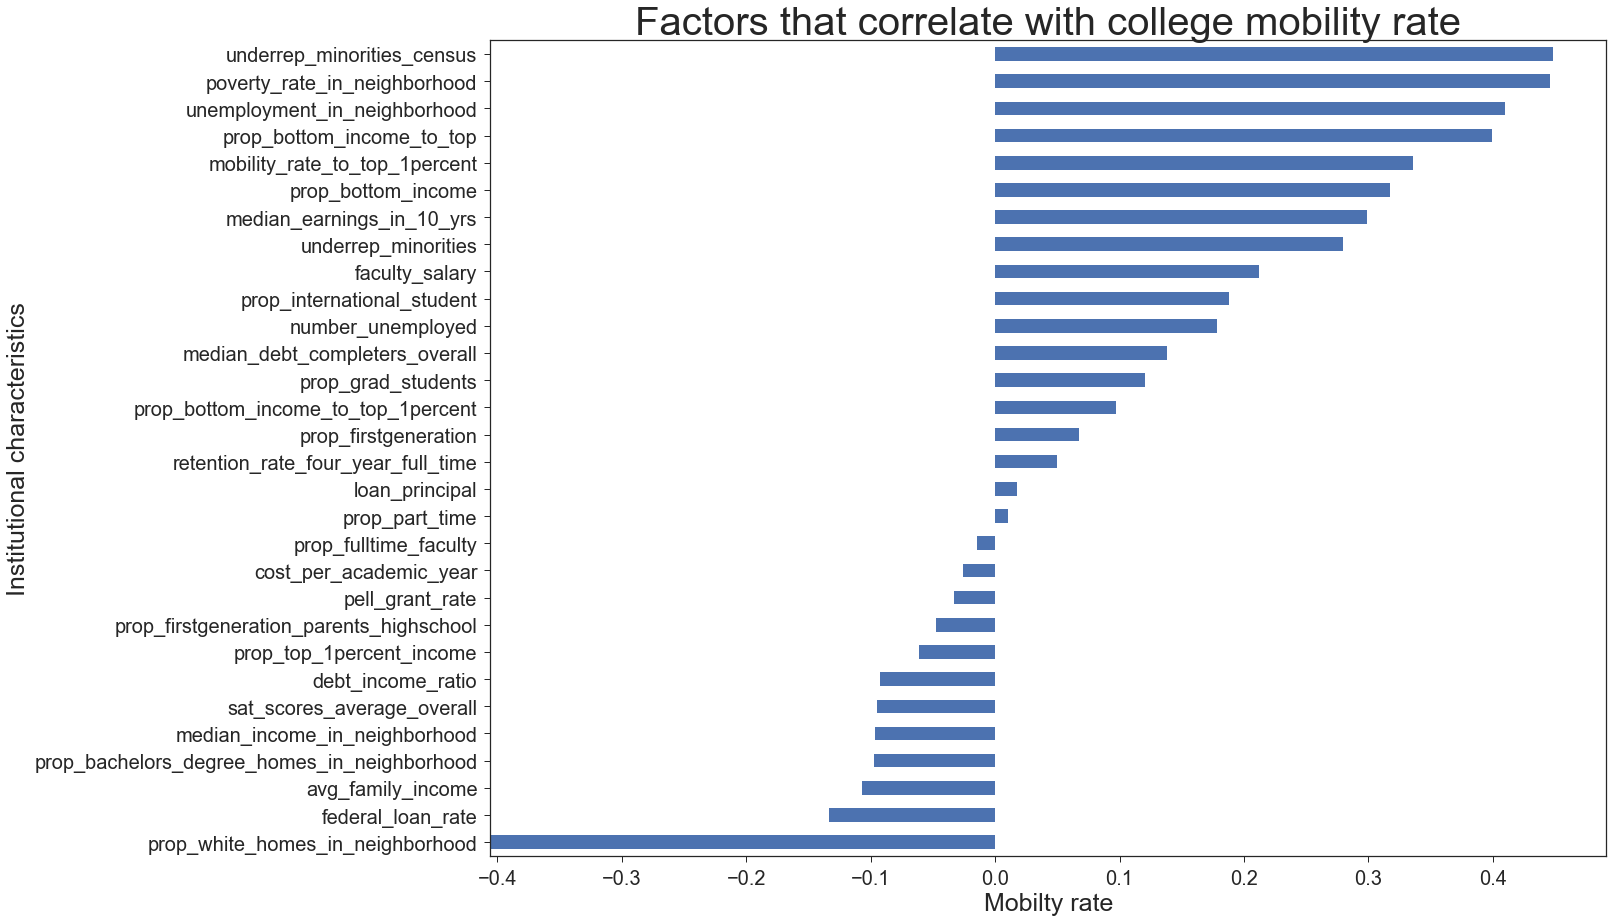

In [65]:
## correlation with just mobility 
plot_data = corr['mobility_rate'].sort_values()
plot_data.drop(plot_data.tail(1).index,inplace=True)
plot_data.plot(kind='barh', figsize=(20, 15))
plt.title('Factors that correlate with mobility rate', fontsize = 40)
plt.xlabel('Mobilty rate', fontsize = 25)
plt.ylabel('Institutional characteristics', fontsize = 25)


## Diversity is important for college mobility rate 
Upward mobility is related to the number of low-income students admitted and to diversity at the institution and where the institution is located. It is also interestingly associated with colleges that have more graduate students, international students, full time faculty that faculty that get paid more (i.e likely bigger universities). 

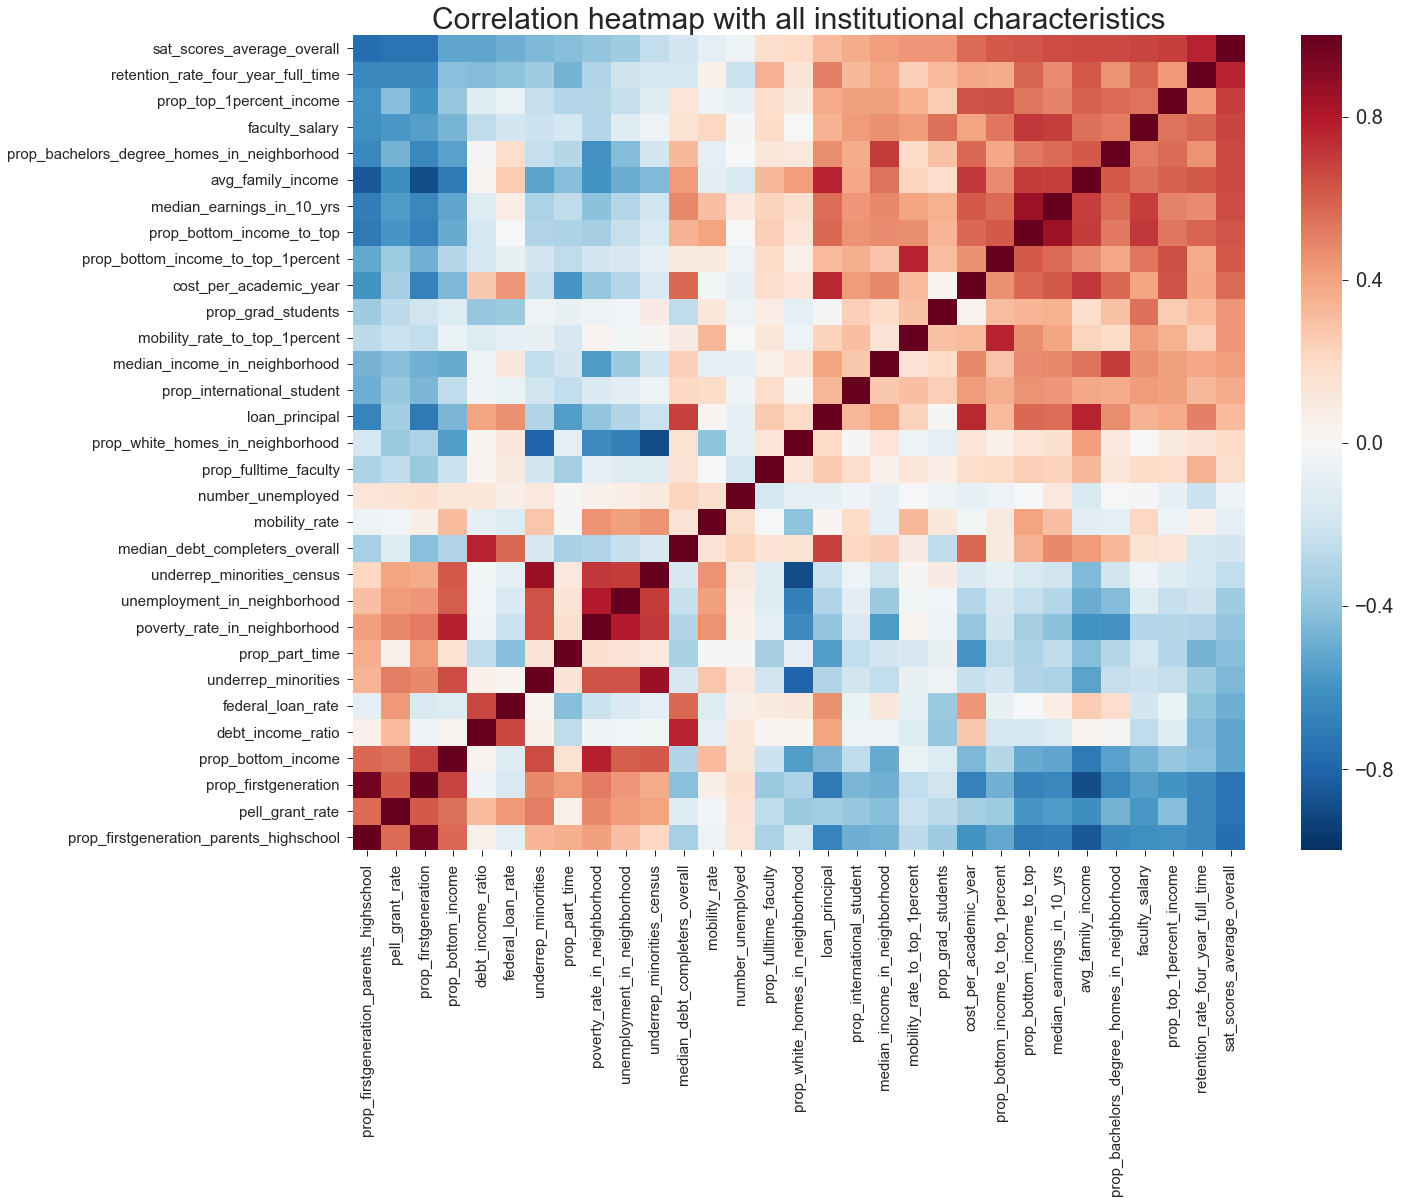

In [67]:
#correlation heatmap
plt.figure(figsize=(20,15))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("")
plt.title('Correlation heatmap with all institutional characteristics', fontsize = 30)
sns.heatmap(corr)
plt.show()

## Elite selective universities and economic mobility

The heat map depicts two data quandrants representing essentially two types of educational institutions: (1) Those that are selective (high averege SAT scores) which have students from top income brackets, high tuition and are in affluent white neighbourhoods with low diversity, and (2) The colleges with more minorities, more first generation students, lower family incomes and in lower income neighbourhoods.     

Mobility is high for low income students who do make it to top selective and expensive universities (prop_bottom_income_to_top). However, these colleges take in very few students from the bottom income brackets (prop_bottom_income). Thus, elite universities are doing a poor job of facilitating upward mobility. These universities don't contribute to the American dream.
 

In [41]:
## test for linear relationships between these variables 
data = df_2013_full[['mobility_rate',
        'debt_income_ratio',
        'median_earnings_in_10_yrs',
        'loan_principal',
        'prop_firstgeneration',
        'underrep_minorities',
        'underrep_minorities_census',
        'poverty_rate_in_neighborhood',
        'prop_white_homes_in_neighborhood',
        'prop_international_student',
        'prop_grad_students',
        'faculty_salary'
        ]].dropna()
response = np.sqrt(data['mobility_rate'])
predictors = data[['debt_income_ratio',
        'median_earnings_in_10_yrs',
        'loan_principal',
        'prop_firstgeneration',
        'underrep_minorities',
        'underrep_minorities_census',
        'poverty_rate_in_neighborhood',
        'prop_white_homes_in_neighborhood',
        'prop_international_student',
        'prop_grad_students',
        'faculty_salary']]
mod = sm.OLS(response, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          mobility_rate   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     2141.
Date:                Tue, 12 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:03:09   Log-Likelihood:                -256.37
No. Observations:                1178   AIC:                             534.7
Df Residuals:                    1167   BIC:                             590.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
debt_inc

#### There are very likely problems with multicollinearity with these data (many of the predictors are very correlated with each other e.g. underrep_minorities and underrep_minorities_census). The solution is dimension reduction (pca) followed by a regression of pca loadings against the response. Nevertheless, nearly all terms are significant at alpha = 0.05 (except the number of grad students and underrepreseted minorities). The effect sizes are large for debt_income_ratio, the number of first generation students and the number of international students. Schools that support a lot of first generation students increase mobility by almost 1%! Schools with an lower debt: income ratio also increase mobility by 0.3%. 

## The top debt incuring institutions    

In [42]:
df_2013_full.sort_values('debt_income_ratio', ascending =False)[['name_broad','debt_income_ratio']].drop_duplicates().head(10)

name_broad  debt_income_ratio
2822                        Florida Memorial University           1.669884
2548  International Academy Of Design And Technology...           1.588966
642                            Central State University           1.564590
1990                              Wright Career College           1.470588
2337                       Saint Augustine's University           1.469124
650                                     Shaw University           1.430627
1421                                   Stillman College           1.415441
1564                                      Paine College           1.404494
2354                         Grambling State University           1.294607
1438                            Philander Smith College           1.291639

## Institutions with top earnings
Many of of institutions with high median incomes focus on applied fields like the health sciences and technology. Surprisingly, Ivy leagues do not make the cut for the top 10 higher earning institutions.  

In [43]:
df_2013_full.sort_values('median_earnings_in_10_yrs', ascending =False)[['name_broad','median_earnings_in_10_yrs']].drop_duplicates().head(10)

name_broad  \
593   Albany College Of Pharmacy And Health Sciences   
2022               Louisiana State University System   
2209                 Saint Louis College Of Pharmacy   
2139                                MCPHS University   
1734           Massachusetts Institute Of Technology   
2483      University Of The Sciences In Philadelphia   
2380                                  Babson College   
1650                              Harvard University   
1576                           Georgetown University   
2202                 Stevens Institute Of Technology   

      median_earnings_in_10_yrs  
593                    122600.0  
2022                   122500.0  
2209                   120400.0  
2139                   112700.0  
1734                    94200.0  
2483                    91800.0  
2380                    91400.0  
1650                    90900.0  
1576                    90100.0  
2202                    87300.0

## Institutions with highest mobility for those who can get in 

In [44]:
# of the low income students, the proportion that make the top 20% (best bet)
df_2013_full.sort_values('prop_bottom_income_to_top', ascending =False)[['name_broad','prop_bottom_income_to_top']].drop_duplicates().head(10)

name_broad  \
2209                 Saint Louis College Of Pharmacy   
2139                                MCPHS University   
593   Albany College Of Pharmacy And Health Sciences   
284                      California Maritime Academy   
2397           Rose - Hulman Institute Of Technology   
912                Advanced Institute Of Hair Design   
2146                            Kettering University   
278                              Harvey Mudd College   
286                        Claremont Mckenna College   
2380                                  Babson College   

      prop_bottom_income_to_top  
2209                  91.929314  
2139                  91.293564  
593                   85.208885  
284                   84.974731  
2397                  78.208527  
912                   77.881294  
2146                  74.689377  
278                   74.350357  
286                   68.282814  
2380                  68.151627

## Institutions with highest mobility rankings

In [45]:
# mobility from bottom 20 to top 20 %
df_2013_full.sort_values('mobility_rate', ascending =False)[['name_broad','mobility_rate']].drop_duplicates().head(10)

name_broad  mobility_rate
1374       Vaughn College Of Aeronautics And Technology      16.357975
555                      CUNY Bernard M. Baruch College      12.938586
2239                    City College Of New York - CUNY      11.723747
1025                                CUNY Lehman College      10.235138
3044           California State University, Los Angeles       9.918455
2234          CUNY John Jay College Of Criminal Justice       9.691438
2139                                   MCPHS University       9.343507
580                                     Pace University       8.432647
994         State University Of New York At Stony Brook       8.412747
2241  New York City College Of Technology Of The Cit...       8.334076

## Institutions with mobility to the top 1%

In [46]:
# mobility from bottom 20 to top 1 %
df_2013_full.sort_values('mobility_rate_to_top_1percent', ascending =False)[['name_broad','mobility_rate_to_top_1percent']].drop_duplicates().head(10)


name_broad  \
286                     Claremont Mckenna College   
2139                             MCPHS University   
3058                   Kiamichi Technology Center   
1432                           Huntingdon College   
243            University Of California, Berkeley   
586   Columbia University In The City Of New York   
703      University Of Texas Of The Permian Basin   
1412           California Institute Of Technology   
555                CUNY Bernard M. Baruch College   
1728                       Maine Maritime Academy   

      mobility_rate_to_top_1percent  
286                        1.249444  
2139                       0.963851  
3058                       0.798517  
1432                       0.778688  
243                        0.763982  
586                        0.750328  
703                        0.737258  
1412                       0.723216  
555                        0.706509  
1728                       0.693706

### Which college type is a good predictor of upward mobility?

#### Applied schools (Buisness, Management, Tech related) tend to be better at increasing economic mobility that those focused on the arts and religion

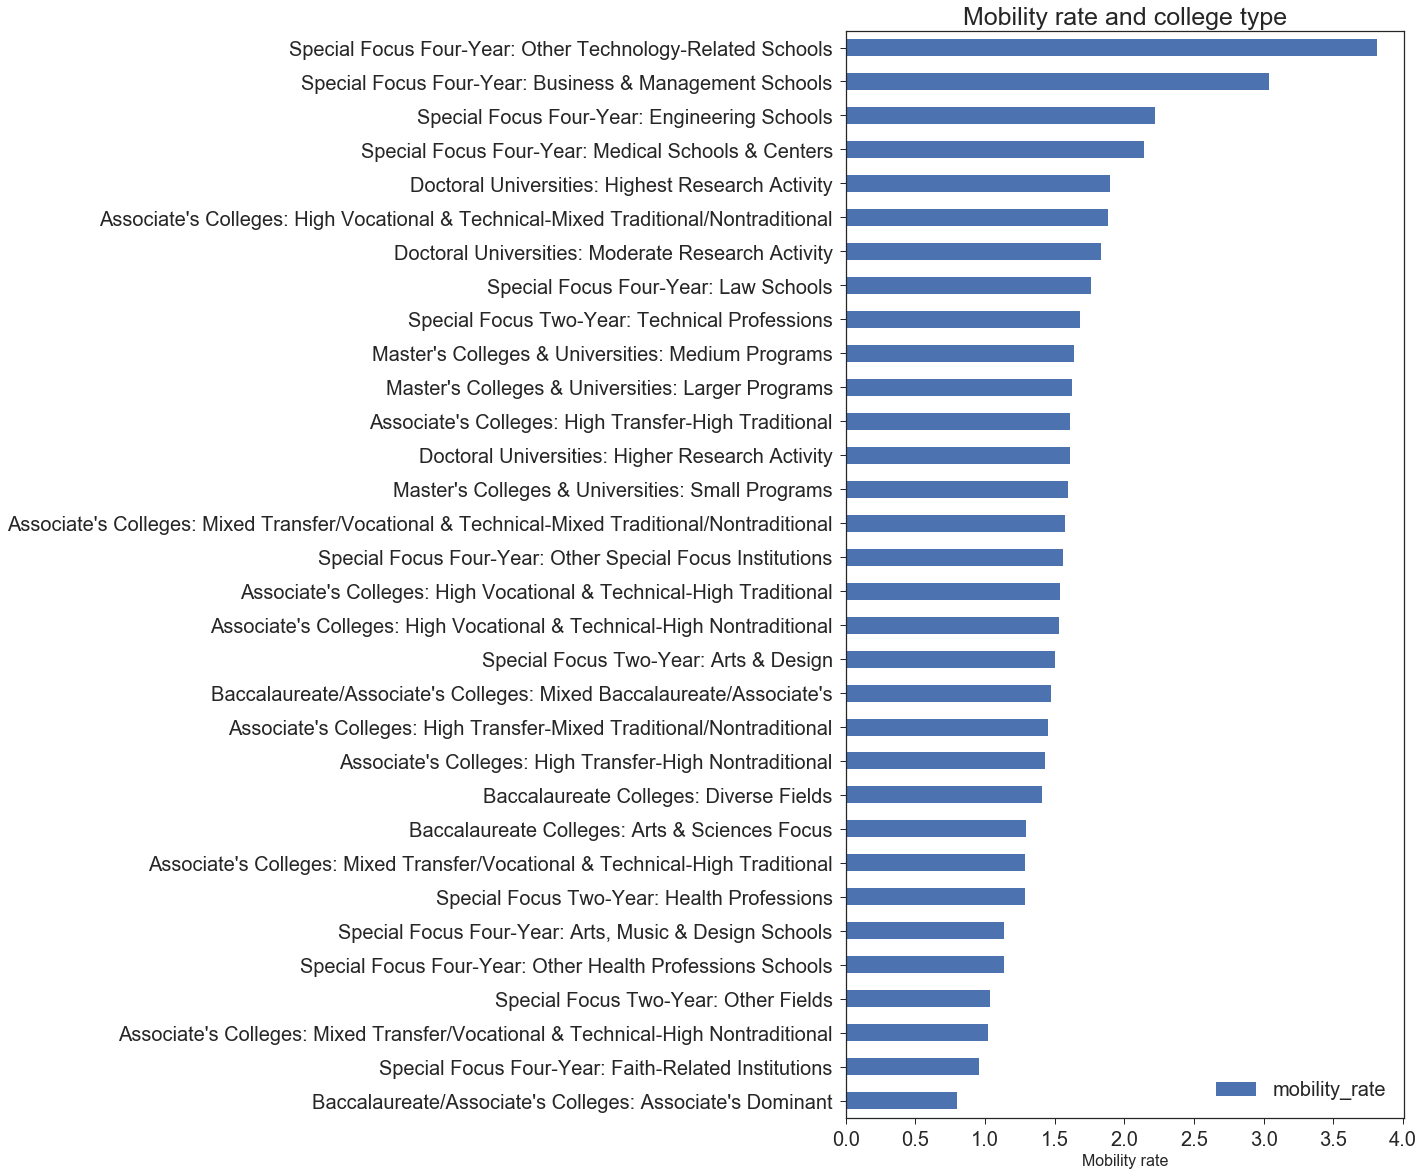

In [81]:
df_2013_full[['carnegie_basic','mobility_rate']].groupby('carnegie_basic').median(). \
sort_values('mobility_rate').plot(kind='barh', figsize=(10, 20))
plt.title('Mobility rate and college type', fontsize = 25)
plt.xlabel('Mobility rate', fontsize = 16)
plt.ylabel("")

### larger, non-residential schools tend to increase economic mobility  

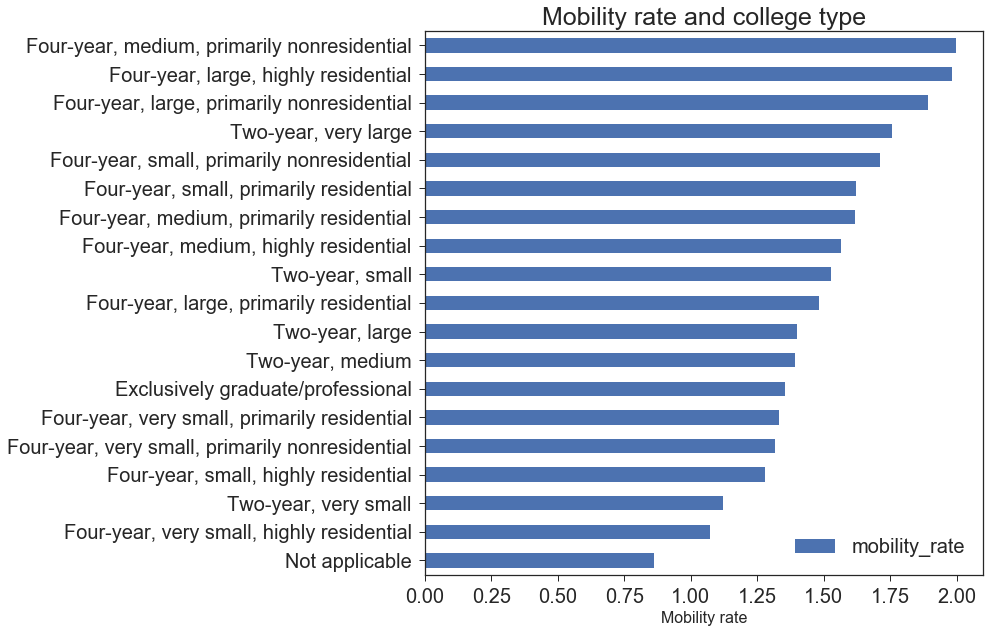

In [80]:
df_2013_full[['carnegie_size_setting','mobility_rate']].groupby('carnegie_size_setting').median(). \
sort_values('mobility_rate').plot(kind='barh', figsize=(10, 10))
plt.title('Mobility rate and college type', fontsize = 25)
plt.xlabel('Mobility rate', fontsize = 16)
plt.ylabel("")

### Inclusive schools tend to increase economic mobility  

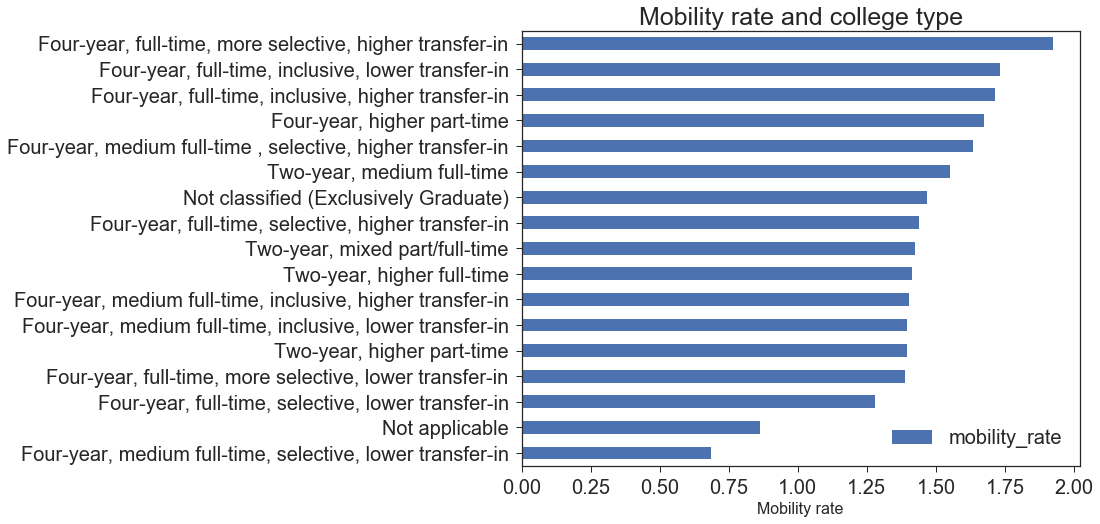

In [79]:
df_2013_full[['carnegie_undergrad','mobility_rate']].groupby('carnegie_undergrad').median(). \
sort_values('mobility_rate').plot(kind='barh', figsize=(10, 8))
plt.title('Mobility rate and college type', fontsize = 25)
plt.xlabel('Mobility rate', fontsize = 16)
plt.ylabel("")

### Rural remote schools or those in large cities are better for economic mobility

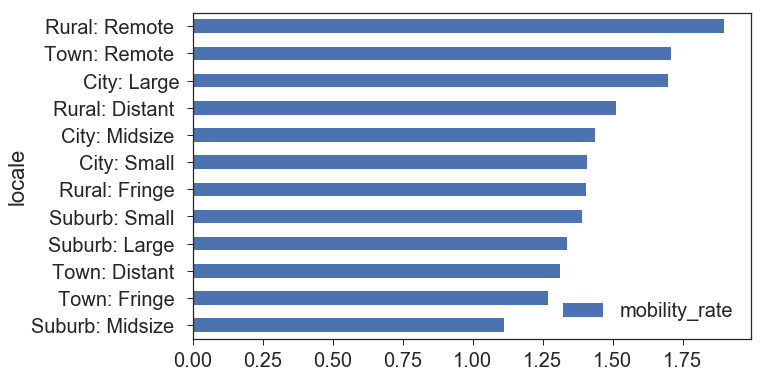

In [50]:
df_2013_full[['locale','mobility_rate']].groupby('locale').median(). \
sort_values('mobility_rate').plot(kind='barh', figsize=(10, 6))

### Diversity matters for upward mobility. Minority serving institutions enroll a large proportion of minority students and have developed strategies to help often-underprepared students succeed in college. These institutions make a huge difference for helping students at lower income levels rise up the economic ladder. 

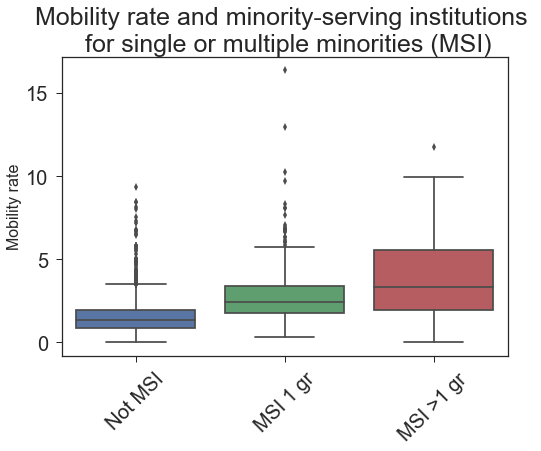

In [78]:
data=df_2013_full[['mobility_rate','minority_serving']].dropna()
MSIdict={0:'Not MSI', 1:'MSI 1 gr', 2:'MSI >1 gr'}
data['minority_serving'].replace(MSIdict, inplace = True)
sns.set(style="ticks", color_codes=True, font_scale=2 )
sns.boxplot(y="mobility_rate", x="minority_serving", data=data)
plt.xticks(rotation=45)
plt.title('Mobility rate and minority-serving institutions \n for single or multiple minorities (MSI)', fontsize = 25)
plt.ylabel('Mobility rate', fontsize = 16)
plt.xlabel("")
plt.show()

### Minority serving institutions for a single underepresented minority increase mobility by 0.2 percent. Those that serve two or more minorities increase mobility by 1%

In [52]:
import statsmodels.formula.api as smf
mod= smf.ols('mobility_rate ~C(minority_serving)', data=data) #Specify C for Categorical
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          mobility_rate   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     249.2
Date:                Tue, 12 Dec 2017   Prob (F-statistic):          1.43e-100
Time:                        19:03:27   Log-Likelihood:                -4623.9
No. Observations:                2895   AIC:                             9254.
Df Residuals:                    2892   BIC:                             9272.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

### Students with the same family income tend to earn more after attending a minority-serving institution.  MSIs also tend to be cheaper

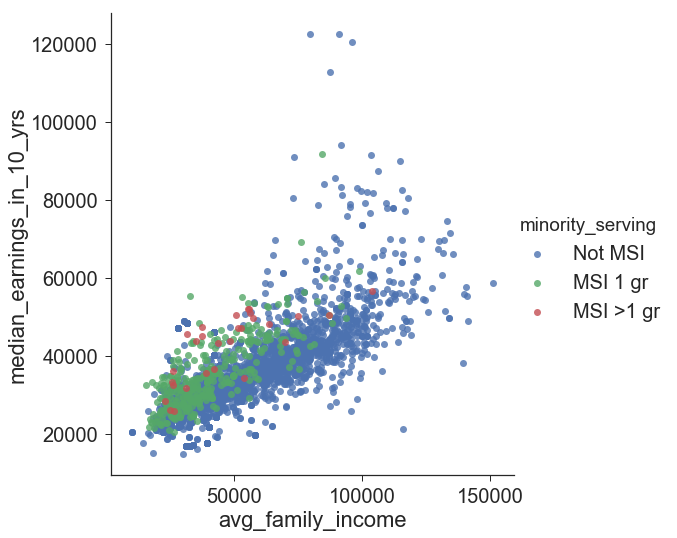

In [53]:
MSIdict={0:'Not MSI', 1:'MSI 1 gr', 2:'MSI >1 gr'}
df_2013_full['minority_serving'].replace(MSIdict, inplace = True)
sns.set(style="ticks", color_codes=True, font_scale=2 )
sns.lmplot(x="avg_family_income", y="median_earnings_in_10_yrs", 
           data=df_2013_full, hue="minority_serving",fit_reg=False, size =8)
plt.show()

### Traditional 4-year institutions engender the highest mobility. Two-year, junior colleges decrease mobility by 2.12% and colleges with shorter programs decrease mobility by almost 2.9%

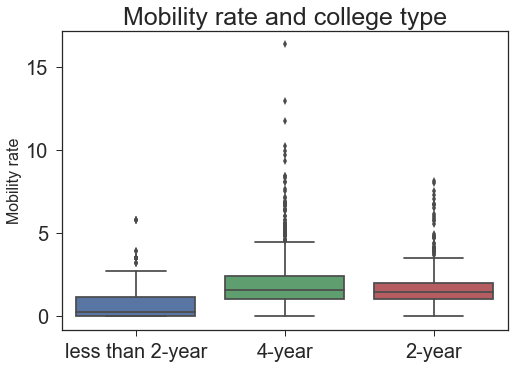

In [77]:
data=df_2013_full[['mobility_rate','institutional_characteristics_level']].dropna()
Instdict={1:'4-year', 2:'2-year', 3:'less than 2-year'}
data['institutional_characteristics_level'].replace(Instdict, inplace = True)
sns.set(style="ticks", color_codes=True, font_scale=2 )
sns.boxplot(y="mobility_rate", x="institutional_characteristics_level", data=data)
plt.title('Mobility rate and college type', fontsize = 25)
plt.ylabel('Mobility rate', fontsize = 16)
plt.xlabel("")
plt.show()

In [55]:
mod= smf.ols('mobility_rate ~C(institutional_characteristics_level)', data=data) #Specify C for Categorical
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          mobility_rate   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     77.85
Date:                Tue, 12 Dec 2017   Prob (F-statistic):           1.04e-33
Time:                        19:03:31   Log-Likelihood:                -5081.4
No. Observations:                3087   AIC:                         1.017e+04
Df Residuals:                    3084   BIC:                         1.019e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------

## What are the top colleges that increase economic mobility based on their selectivity (SAT scores)?  
I binned SAT scores to three categories, low, medium and high here are the top institions per category. Here I also look at   

In [56]:
sat_cat=('low','medium','high')
#sat_cat=('ignore','low1','low2','medium','high')
df_2013_full['sat_scores_bins'] =pd.cut(df_2013_full['sat_scores_average_overall'],3, labels =sat_cat)

### Top schools for high-access, low selectivity (low SAT scores)

In [57]:
df_2013_full[(df_2013_full['sat_scores_bins'] =='low')]. \
sort_values('prop_bottom_income_to_top', ascending=False) \
[['name_broad','prop_bottom_income_to_top','median_earnings_in_10_yrs','sat_scores_average_overall']].head(10)     

name_broad  prop_bottom_income_to_top  \
2129                            Nichols College                  52.332180   
2284                      Saint Francis College                  49.203571   
2256              Dominican College Of Blauvelt                  48.201897   
235       California State University, East Bay                  43.979919   
2850                    Albertus Magnus College                  42.551868   
2277                              Utica College                  38.360474   
348                  University Of Saint Joseph                  37.989376   
2234  CUNY John Jay College Of Criminal Justice                  35.684139   
939                            Caldwell College                  34.991135   
233    California State University, Bakersfield                  32.759682   

      median_earnings_in_10_yrs  sat_scores_average_overall  
2129                    48100.0                       940.0  
2284                    44400.0                       940.0  
2256                    45900.0                       899.0  
235                     50500.0                       910.0  
2850                    51200.0                       830.0  
2277                    44100.0                       946.0  
348                     48800.0                       950.0  
2234                    43300.0                       950.0  
939                     41700.0                       949.0  
233                     46600.0                       901.0

### Top schools for intermediate selectivity  (median SAT scores)

In [58]:
df_2013_full[(df_2013_full['sat_scores_bins'] =='medium')]. \
sort_values('prop_bottom_income_to_top', ascending=False) \
[['name_broad','prop_bottom_income_to_top','median_earnings_in_10_yrs','sat_scores_average_overall']].head(10) 

name_broad  \
2209                 Saint Louis College Of Pharmacy   
2139                                MCPHS University   
593   Albany College Of Pharmacy And Health Sciences   
284                      California Maritime Academy   
2146                            Kettering University   
575               New Jersey Institute Of Technology   
2483      University Of The Sciences In Philadelphia   
1656                  Massachusetts Maritime Academy   
1257                   University Of Mary Washington   
2142                              Bentley University   

      prop_bottom_income_to_top  median_earnings_in_10_yrs  \
2209                  91.929314                   120400.0   
2139                  91.293564                   112700.0   
593                   85.208885                   122600.0   
284                   84.974731                    79000.0   
2146                  74.689377                    78600.0   
575                   63.790905                    65900.0   
2483                  62.914597                    91800.0   
1656                  61.262119                    79300.0   
1257                  60.731060                    50500.0   
2142                  60.582417                    80600.0   

      sat_scores_average_overall  
2209                      1228.0  
2139                      1094.0  
593                       1195.0  
284                       1080.0  
2146                      1198.0  
575                       1142.0  
2483                      1165.0  
1656                      1051.0  
1257                      1110.0  
2142                      1234.0

### Top schools for high SAT scores

In [59]:
df_2013_full[(df_2013_full['sat_scores_bins'] =='high')]. \
sort_values('prop_bottom_income_to_top', ascending=False) \
[['name_broad','prop_bottom_income_to_top','median_earnings_in_10_yrs','sat_scores_average_overall']].head(10)

name_broad  prop_bottom_income_to_top  \
2397  Rose - Hulman Institute Of Technology                  78.208527   
278                     Harvey Mudd College                  74.350357   
286               Claremont Mckenna College                  68.282814   
2380                         Babson College                  68.151627   
1734  Massachusetts Institute Of Technology                  66.528679   
1412     California Institute Of Technology                  66.062187   
2177                   Princeton University                  65.865234   
583        Rensselaer Polytechnic Institute                  64.620743   
2757               Colorado School Of Mines                  64.041260   
2942                    Stanford University                  62.739227   

      median_earnings_in_10_yrs  sat_scores_average_overall  
2397                    79200.0                      1310.0  
278                     74200.0                      1483.0  
286                     75000.0                      1397.0  
2380                    91400.0                      1258.0  
1734                    94200.0                      1503.0  
1412                    74200.0                      1534.0  
2177                    80500.0                      1495.0  
583                     77900.0                      1366.0  
2757                    82100.0                      1298.0  
2942                    85700.0                      1466.0

## Are there geographic patterns to economic mobility?  

In [69]:
mean_mobility_state = df_2013_full[["state","mobility_rate"]].groupby("state").median()
mean_mobility_state.reset_index(inplace=True)
mean_cost_state = df_2013_full[["state","cost_per_academic_year"]].groupby("state").median()
mean_cost_state.reset_index(inplace=True)

In [70]:
import plotly 
plotly.tools.set_credentials_file(username='tjogesh', api_key='jQCndI6d5M1oYF4mXX7i')

In [98]:
scl = [[0.0, 'rgb(0, 51, 204)'],[0.2, 'rgb(51, 153, 255)'],[0.4, 'rgb(204, 204, 255)'],\
            [0.6, 'rgb(255, 204, 204)'],[0.8, 'rgb(255, 102, 0)'],[1.0, 'rgb(153, 0, 0)']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = mean_mobility_state['state'],
        z = mean_mobility_state['mobility_rate'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Mobility ranking")
        ) ]

layout = dict(
        title = 'Average college mobility rate by state',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
plotly.plotly.iplot( fig, filename='mobility-cloropleth-map' )


### Colleges in mid-western state have surprisingly low economic mobility whereas those with high immigrant populations (NY, TX, CA) have higher mobility on average

In [99]:
scl = [[0.0, 'rgb(0, 51, 204)'],[0.2, 'rgb(51, 153, 255)'],[0.4, 'rgb(204, 204, 255)'],\
            [0.6, 'rgb(255, 204, 204)'],[0.8, 'rgb(255, 102, 0)'],[1.0, 'rgb(153, 0, 0)']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = mean_cost_state['state'],
        z = mean_cost_state['cost_per_academic_year'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Average cost per year")
        ) ]

layout = dict(
        title = 'Average cost of attending college by state',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
plotly.plotly.iplot( fig, filename='d3-cloropleth-map' )


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tjogesh/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


### Interestingly, colleges in mid-western states are more expensive on average! This might be why mobility rates are on average lower for institutions in these states

# ACADEMICS

In [72]:
academic_df_2013 = allyears_academic_df[(allyears_academic_df['year']==2013)]
df_2013_full_academics = pd.merge(academic_df_2013, df_2013_full, left_on='id', right_on='id')
#academic_df_2013.head()

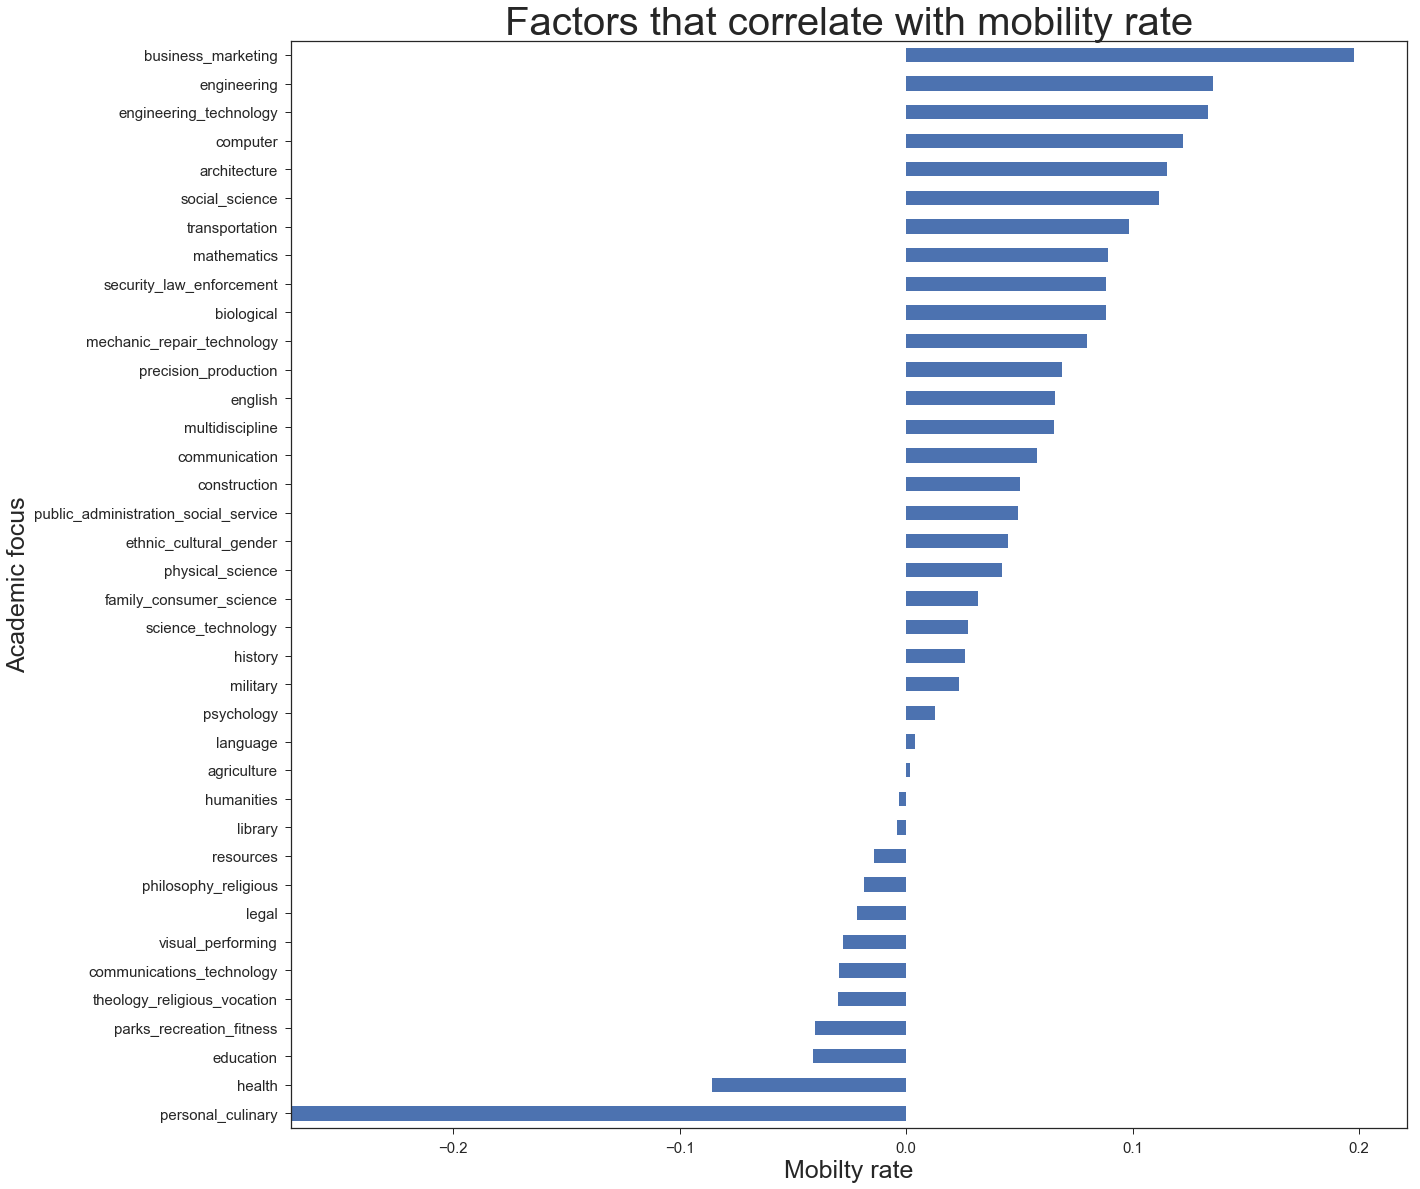

In [75]:
### correlation heatmap to look for important relationships. 
data = df_2013_full_academics[['mobility_rate',      
                     'academics.program_percentage.agriculture',
                     'academics.program_percentage.architecture',
                     'academics.program_percentage.biological',
                     'academics.program_percentage.business_marketing',
                     'academics.program_percentage.communication',
                     'academics.program_percentage.communications_technology',
                     'academics.program_percentage.computer',
                     'academics.program_percentage.construction',
                     'academics.program_percentage.education',
                     'academics.program_percentage.engineering',
                     'academics.program_percentage.engineering_technology',
                     'academics.program_percentage.english',
                     'academics.program_percentage.ethnic_cultural_gender',
                     'academics.program_percentage.family_consumer_science',
                     'academics.program_percentage.health',
                     'academics.program_percentage.history',
                     'academics.program_percentage.humanities',
                     'academics.program_percentage.language',
                     'academics.program_percentage.legal',
                     'academics.program_percentage.library',
                     'academics.program_percentage.mathematics',
                     'academics.program_percentage.mechanic_repair_technology',
                     'academics.program_percentage.military',
                     'academics.program_percentage.multidiscipline',
                     'academics.program_percentage.parks_recreation_fitness',
                     'academics.program_percentage.personal_culinary',
                     'academics.program_percentage.philosophy_religious',
                     'academics.program_percentage.physical_science',
                     'academics.program_percentage.precision_production',
                     'academics.program_percentage.psychology',
                     'academics.program_percentage.public_administration_social_service',
                     'academics.program_percentage.resources',
                     'academics.program_percentage.science_technology',
                     'academics.program_percentage.security_law_enforcement',
                     'academics.program_percentage.social_science',
                     'academics.program_percentage.theology_religious_vocation',
                     'academics.program_percentage.transportation',
                     'academics.program_percentage.visual_performing'
                    ]]

replace = "academics.program_percentage."
data.columns= [re.sub(replace,'', s) for s in data.columns] 

corr = data.corr()
#corr.sort_values('mobility_rate', axis =0, inplace = True, ascending = False)
plot_data = corr['mobility_rate'].sort_values()
plot_data.drop(plot_data.tail(1).index,inplace=True)
plot_data.plot(kind='barh', figsize=(20, 20))

#plt.figure(figsize=(20,15))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Factors that correlate with mobility rate', fontsize = 40)
plt.xlabel('Mobilty rate', fontsize = 25)
plt.ylabel('Academic focus', fontsize = 25)
plt.show()## Missing data

## ----------------------------------
## College Recommender 
## ----------------------------------

## Analysis Pipeline:
- Classify colleges into unsupervised clusters (for different states) based on SAT scores (selectivity), cost, programs offered. Use K means clustering as it produces even clusters. I specify the number of clusters so that the data are split in approximately ~ 20 colleges per cluster
- Determine the efficiency of the clustering using a supervised model to see how well, a ML algorithm can predict cluster classification based on the same features. 
- Use this classifier to predict in-state colleges that students may be able to attend, given the cost of the university, their SAT scores and location (State)
- display the options with the mobility opportunities that the college provides. 


In [82]:
#handle missing data by imputing medians
from sklearn.preprocessing import Imputer
impute = Imputer(strategy='median')

In [83]:
### Converting academic propotions to presence absence data i.e does the school have a program 
list_drop = ['Unnamed: 0','id','school.name','metadata','year'] 
academic_programs = academic_df_2013.drop(list_drop,axis = 1)
#s[s>1] = 0
academic_programs[academic_programs>0]=1
academic_programs.head()
academic_programs['id'] = academic_df_2013['id']
student_academics = pd.merge(academic_programs, df_2013_full, left_on='id', right_on='id')

#list(academic_programs.columns)

In [84]:
## simplyfying carnegie_undergrad to two classes 2-year ve 4-year institutions 
student_academics['undergrad_length']=student_academics['carnegie_undergrad'].str.rsplit(',', expand=True)[0]

In [101]:
cluster_features = student_academics[['school_name','state',
                     'academics.program_percentage.agriculture',
                     'academics.program_percentage.architecture',
                     'academics.program_percentage.biological',
                     'academics.program_percentage.business_marketing',
                     'academics.program_percentage.communication',
                     'academics.program_percentage.communications_technology',
                     'academics.program_percentage.computer',
                     'academics.program_percentage.construction',
                     'academics.program_percentage.education',
                     'academics.program_percentage.engineering',
                     'academics.program_percentage.engineering_technology',
                     'academics.program_percentage.english',
                     'academics.program_percentage.ethnic_cultural_gender',
                     'academics.program_percentage.family_consumer_science',
                     'academics.program_percentage.health',
                     'academics.program_percentage.history',
                     'academics.program_percentage.humanities',
                     'academics.program_percentage.language',
                     'academics.program_percentage.legal',
                     'academics.program_percentage.library',
                     'academics.program_percentage.mathematics',
                     'academics.program_percentage.mechanic_repair_technology',
                     'academics.program_percentage.military',
                     'academics.program_percentage.multidiscipline',
                     'academics.program_percentage.parks_recreation_fitness',
                     'academics.program_percentage.personal_culinary',
                     'academics.program_percentage.philosophy_religious',
                     'academics.program_percentage.physical_science',
                     'academics.program_percentage.precision_production',
                     'academics.program_percentage.psychology',
                     'academics.program_percentage.public_administration_social_service',
                     'academics.program_percentage.resources',
                     'academics.program_percentage.science_technology',
                     'academics.program_percentage.security_law_enforcement',
                     'academics.program_percentage.social_science',
                     'academics.program_percentage.theology_religious_vocation',
                     'academics.program_percentage.transportation',
                     'academics.program_percentage.visual_performing',
                     'sat_scores_midpoint_critical_reading',
                     'sat_scores_midpoint_math',
                     'sat_scores_midpoint_writing',
                     'cost_per_academic_year',
                     'prop_bottom_income_to_top',
                     'avg_family_income',
                     'median_earnings_in_10_yrs',
                     #'mobility_rate',                
                     'undergrad_length'                                        
                    ]]

### imputing the SAT scores based on average family income of the college (slope = 0.006). The two variables are tightly correlated R2 >0.90

In [102]:
cluster_features.loc[cluster_features['sat_scores_midpoint_critical_reading'].isnull(), \
                     'sat_scores_midpoint_critical_reading'] = cluster_features['avg_family_income']*0.0066
cluster_features.loc[cluster_features['sat_scores_midpoint_math'].isnull(), \
                     'sat_scores_midpoint_math'] = cluster_features['avg_family_income']*0.0068
cluster_features.loc[cluster_features['sat_scores_midpoint_writing'].isnull(), \
                     'sat_scores_midpoint_writing'] = cluster_features['avg_family_income']*0.0064

In [103]:
#create unique list of names
location = cluster_features.state.unique()

#create a data frame dictionary to store your data frames
localDict = {loc : cluster_features for loc in location}

for key in localDict.keys():
    localDict[key] = cluster_features[:][cluster_features.state == key]

#localDict.pop('Outlying Areas (AS, FM, GU, MH, MP, PR, PW, VI)',None) # only one sample
#remove states with less than 10 schools
[localDict.pop(key) for key in ['AK','PR']]
localDict.keys()

['WA',
 'ND',
 'DE',
 'DC',
 'WI',
 'WV',
 'HI',
 'FL',
 'WY',
 'NH',
 'NJ',
 'NM',
 'TX',
 'LA',
 'NC',
 'NE',
 'TN',
 'NY',
 'PA',
 'RI',
 'NV',
 'VA',
 'CO',
 'CA',
 'AL',
 'AR',
 'VT',
 'IL',
 'GA',
 'IN',
 'IA',
 'OK',
 'AZ',
 'ID',
 'CT',
 'ME',
 'MD',
 'MA',
 'OH',
 'UT',
 'MO',
 'MN',
 'MI',
 'KS',
 'MT',
 'MS',
 'SC',
 'KY',
 'OR',
 'SD']

In [104]:
cols_to_transform = ['undergrad_length','state']
cols_to_drop = ['school_name','median_earnings_in_10_yrs','avg_family_income','prop_bottom_income_to_top']
data = {}
dfs= {}
for key in localDict.keys():
    df = pd.get_dummies(localDict[key], columns = cols_to_transform )
    X = df.drop(cols_to_drop, axis =1).values
    X_new = impute.fit_transform(X)
    data.update({key:X_new})
    dfs.update({key:df})
    #print key, df.shape, X_new.shape


In [105]:
from sklearn.ensemble import RandomForestClassifier
def cluster_test(x, cluster):
    xtrain, xtest, ytrain, ytest = train_test_split(x,cluster, test_size=0.30)
    forest = RandomForestClassifier(n_estimators = 100) 
    forest = forest.fit(xtrain, ytrain)
    training_accuracy = forest.score(xtrain, ytrain)
    test_accuracy = forest.score(xtest, ytest)
    print("Accuracy on training data: {:2f}".format(training_accuracy))
    print("Accuracy on test data:     {:2f}".format(test_accuracy))
    return forest, test_accuracy

In [106]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
labels = {}
student_data_model = {}
model_accuracy = {}
cluster_number = {}
for key in data.keys():
    if len(data[key])< 10: #less than 10 schools per state
        model = KMeans(n_clusters=2) #~20 schools per cluster
        cluster_number.update({key:2})
        label=model.fit_predict(data[key])
        dfs[key]['cluster'] = label
        print("State: {}, No. of clusters: 2".format(key)) 
        forest, accuracy = cluster_test(data[key], label)
        student_data_model.update({key:forest})
        model_accuracy.update({key:accuracy})
    if len(data[key])> 40:
        model = KMeans(n_clusters=len(data[key])/20) #~20 schools per cluster
        cluster_number.update({key:len(data[key])/20})
        label=model.fit_predict(data[key])
        dfs[key]['cluster'] = label
        print("State: {}, No. of clusters: {}".format(key, len(data[key])/20)) 
        forest, accuracy = cluster_test(data[key], label)
        student_data_model.update({key:forest})
        model_accuracy.update({key:accuracy})
    else: 
        model = KMeans(n_clusters=len(data[key])/5)# between 10 and 40 schools per cluster
        cluster_number.update({key:len(data[key])/5})
        label=model.fit_predict(data[key])
        dfs[key]['cluster'] = label
        print("State: {}, No. of clusters: {}".format(key, len(data[key])/5)) 
        forest, accuracy = cluster_test(data[key], label)
        student_data_model.update({key:forest})
        model_accuracy.update({key:accuracy})
        
    


State: WA, No. of clusters: 3
Accuracy on training data: 1.000000
Accuracy on test data:     0.909091
State: DE, No. of clusters: 2
Accuracy on training data: 1.000000
Accuracy on test data:     1.000000
State: DE, No. of clusters: 1
Accuracy on training data: 1.000000
Accuracy on test data:     1.000000
State: DC, No. of clusters: 2
Accuracy on training data: 1.000000
Accuracy on test data:     1.000000
State: WI, No. of clusters: 3
Accuracy on training data: 1.000000
Accuracy on test data:     1.000000
State: WV, No. of clusters: 4
Accuracy on training data: 1.000000
Accuracy on test data:     0.714286
State: HI, No. of clusters: 2
Accuracy on training data: 1.000000
Accuracy on test data:     0.666667
State: HI, No. of clusters: 1
Accuracy on training data: 1.000000
Accuracy on test data:     1.000000
State: FL, No. of clusters: 7
Accuracy on training data: 1.000000
Accuracy on test data:     0.891304
State: WY, No. of clusters: 2
Accuracy on training data: 1.000000
Accuracy on test

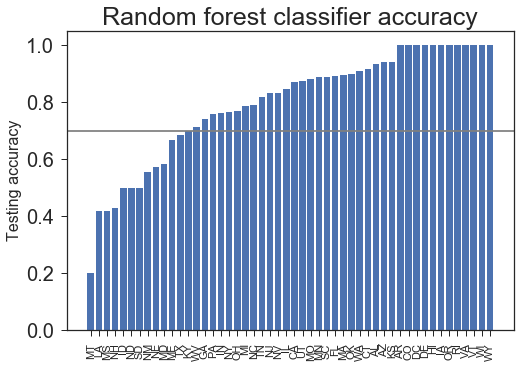

In [117]:
from collections import OrderedDict
model_accuracy = OrderedDict(sorted(model_accuracy.items(), key=lambda(k,v):(v,k)))
plt.bar(range(len(model_accuracy)), model_accuracy.values(), align='center')
plt.xticks(range(len(model_accuracy)), list(model_accuracy.keys()), fontsize = 11, rotation='vertical')
plt.axhline(0.7, color="gray")
plt.title('Random forest classifier accuracy', fontsize = 25)
plt.ylabel("Testing accuracy", fontsize = 16)
plt.show()

### Clustering and classification work really well for some states (high accuracy) but poorly for others

In [91]:
import re
from ipywidgets import widgets
from IPython.display import display


data_to_enter = list(dfs['CA'].columns)
style = {'description_width': 'initial'}

### state 
states = localDict.keys()
states_dropdown = widgets.Dropdown(options=states, value = None, description ="State of residence", style = style)

### programs 
programs = data_to_enter[1:39]
replace = "academics.program_percentage."
programs= [re.sub(replace,'', s) for s in programs] 
program_dropdown1 = widgets.Dropdown(options=programs, value = None, description ="Major choice 1", style = style)
program_dropdown2 = widgets.Dropdown(options=programs, value = None, description ="Major choice 2", style = style)
program_dropdown3 = widgets.Dropdown(options=programs, value = None, description ="Major choice 3", style = style)


### institution type 
inst = data_to_enter[46:50]
replace = "undergrad_length_"
inst= [re.sub(replace,'', s) for s in inst] 
inst_dropdown = widgets.Dropdown(options=inst, value = None, description ="Institution Type", style = style)

### SAT scores
sat_math_slider = widgets.IntSlider(min=cluster_features.sat_scores_midpoint_math.min(), \
                                    max=cluster_features.sat_scores_midpoint_math.max(), \
                                    step=20, description ="SAT score math", \
                                    style=style)
sat_writing_slider = widgets.IntSlider(min=cluster_features.sat_scores_midpoint_writing.min(), \
                                    max=cluster_features.sat_scores_midpoint_writing.max(), \
                                    step=20, description ="SAT score writing", \
                                    style=style)
sat_read_slider = widgets.FloatSlider(min=cluster_features.sat_scores_midpoint_critical_reading.min(), \
                                    max=cluster_features.sat_scores_midpoint_critical_reading.max(), \
                                    step=20, description ="SAT score reading", \
                                    style=style, \
                                    continuous_update = False)
cost_slider = widgets.IntSlider(min=cluster_features.cost_per_academic_year.min(), \
                                    max=cluster_features.cost_per_academic_year.max(), \
                                    step=10000, description ="Cost per year", \
                                    style=style)

### family income
mobility_slider = widgets.IntSlider(min=cluster_features.prop_bottom_income_to_top.min(), \
                                    max=cluster_features.prop_bottom_income_to_top.max(), \
                                    step=1, description ="Economic Mobility", \
                                    style=style)

submit_button = widgets.Button(description ="Run Prediction")



In [92]:
import plotly.plotly as py
import plotly.graph_objs as go
import math

def plot_bubble(state, cluster):
    #print("this works!")
    state_df = dfs[state]
    new_df =state_df[state_df['cluster'] == cluster]
    hover_text = []
    bubble_size = []

    for index, row in new_df.iterrows():
        hover_text.append(('School: {school_name}<br>'+
                          'Mobility: {prop_bottom_income_to_top}<br>'+
                          'Cost: {cost_per_academic_year}').format(school_name=row['school_name'],
                                                prop_bottom_income_to_top=row['prop_bottom_income_to_top'],
                                                cost_per_academic_year=row['cost_per_academic_year']))
        bubble_size.append((row['prop_bottom_income_to_top']))

    #new_df['text'] = hover_text
    #new_df['size'] = bubble_size
    sizeref = 2*max(bubble_size)/(60**2) #2*max(new_df['size'])/(60**2)

    trace0 = go.Scatter(
        x=new_df['cost_per_academic_year'],
        y=new_df['median_earnings_in_10_yrs'],
        mode='markers',
        name=state,
        text=hover_text, #new_df['text'], 
        marker=dict(
            symbol='circle',
            sizemode='area',
            sizeref=sizeref/2,
            size=bubble_size, #new_df['size'],
            line=dict(
                width=2
            ),
        )
    )

    data = [trace0]
    layout = go.Layout(
        title='Cost vs Median earnings for your schools in {}. Bubbles are proportional to economic mobility'.format(state),
        xaxis=dict(
            title='Cost per year ',
            gridcolor='rgb(255, 255, 255)',
            #range=[2.003297660701705, 5.191505530708712],
            #type='log',
            #zerolinewidth=1,
            #ticklen=5,
            #gridwidth=2,
        ),
        yaxis=dict(
            title='Median earnings',
            gridcolor='rgb(255, 255, 255)',
            #range=[36.12621671352166, 91.72921793264332],
           # zerolinewidth=1,
            #ticklen=5,
            #gridwidth=2,
        ),
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
    )

    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='test') 


In [96]:

def plot_importance(state, model=student_data_model):
    ### -- takes state value and plots importance of features in random forest model -- ###
    feature_list = list(dfs[state].columns) 
    feature_list.remove('school_name')
    feature_list.remove('median_earnings_in_10_yrs')
    feature_list.remove('prop_bottom_income_to_top')
    feature_list.remove('avg_family_income')
    feature_list.remove('cluster')
    #feature_list.remove('mobility_rate')
    importances = model[state].feature_importances_
    feature_importance = pd.DataFrame(zip(feature_list, importances), columns = ('feature','importance'))
    feature_importance.set_index('feature', inplace=True)
    feature_importance.sort_values('importance').plot(kind='barh', figsize=(15, 25))
    plt.axvline(0.1, color="gray")
    plt.title('Feature importance for the random forest classifier', fontsize = 25)
    plt.xlabel('Importance', fontsize = 16)
    plt.ylabel("")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()## Missing data

    
def run_ML(c):
    feature_list = list(dfs[states_dropdown.value].columns) 
    feature_list.remove('school_name')
    feature_list.remove('median_earnings_in_10_yrs')
    feature_list.remove('prop_bottom_income_to_top')
    feature_list.remove('avg_family_income')
    feature_list.remove('cluster')
    #feature_list.remove('mobility_rate')
    array = [0] * len(feature_list)
    p1 = "academics.program_percentage."+program_dropdown1.value
    p2 = "academics.program_percentage."+program_dropdown2.value
    p3 = "academics.program_percentage."+program_dropdown3.value
    inst = "undergrad_length_"+ inst_dropdown.value
    for i in range(0,len(feature_list)):
        if feature_list[i]==p1 or feature_list[i]==p2 or feature_list[i]==p3 or feature_list[i]==inst:
            array[i]=1
        else:
            array[i]=0
        if feature_list[i]=='sat_scores_midpoint_critical_reading':
            array[i]=sat_read_slider.value 
        if feature_list[i]=='sat_scores_midpoint_math':
            array[i]=sat_math_slider.value 
        if feature_list[i]=='sat_scores_midpoint_writing':
            array[i]=sat_writing_slider.value 
        if feature_list[i]=='cost_per_academic_year':
            array[i]=cost_slider.value
        if feature_list[i]=='prop_bottom_income_to_top':
            array[i] = mobility_slider.value 
    X_predict = np.array(array)
    X_predict=X_predict.reshape(1, -1)
    y_predict=student_data_model[states_dropdown.value].predict(X_predict)
    global state
    state = states_dropdown.value
    global cluster
    cluster = int(y_predict)
    print("Prediction accuracy is {}".format(model_accuracy[state]))
    print("Complete! View graph below")
       

In [118]:
display(states_dropdown)
display(program_dropdown1)
display(program_dropdown2)
display(program_dropdown3)
display(sat_math_slider)
display(sat_writing_slider)
display(sat_read_slider)
display(cost_slider)
display(inst_dropdown)
display(submit_button)
#display(mobility_slider)
#, description ="SAT score math"

submit_button.on_click(run_ML)


Dropdown(description=u'State of residence', index=23, options=('WA', 'ND', 'DE', 'DC', 'WI', 'WV', 'HI', 'FL', 'WY', 'NH', 'NJ', 'NM', 'TX', 'LA', 'NC', 'NE', 'TN', 'NY', 'PA', 'RI', 'NV', 'VA', 'CO', 'CA', 'AL', 'AR', 'VT', 'IL', 'GA', 'IN', 'IA', 'OK', 'AZ', 'ID', 'CT', 'ME', 'MD', 'MA', 'OH', 'UT', 'MO', 'MN', 'MI', 'KS', 'MT', 'MS', 'SC', 'KY', 'OR', 'SD'), style=DescriptionStyle(description_width=u'initial'), value='CA')

Dropdown(description=u'Major choice 1', index=5, options=('agriculture', 'architecture', 'biological', 'business_marketing', 'communication', 'communications_technology', 'computer', 'construction', 'education', 'engineering', 'engineering_technology', 'english', 'ethnic_cultural_gender', 'family_consumer_science', 'health', 'history', 'humanities', 'language', 'legal', 'library', 'mathematics', 'mechanic_repair_technology', 'military', 'multidiscipline', 'parks_recreation_fitness', 'personal_culinary', 'philosophy_religious', 'physical_science', 'precision_production', 'psychology', 'public_administration_social_service', 'resources', 'science_technology', 'security_law_enforcement', 'social_science', 'theology_religious_vocation', 'transportation', 'visual_performing'), style=DescriptionStyle(description_width=u'initial'), value='communications_technology')

Dropdown(description=u'Major choice 2', index=9, options=('agriculture', 'architecture', 'biological', 'business_marketing', 'communication', 'communications_technology', 'computer', 'construction', 'education', 'engineering', 'engineering_technology', 'english', 'ethnic_cultural_gender', 'family_consumer_science', 'health', 'history', 'humanities', 'language', 'legal', 'library', 'mathematics', 'mechanic_repair_technology', 'military', 'multidiscipline', 'parks_recreation_fitness', 'personal_culinary', 'philosophy_religious', 'physical_science', 'precision_production', 'psychology', 'public_administration_social_service', 'resources', 'science_technology', 'security_law_enforcement', 'social_science', 'theology_religious_vocation', 'transportation', 'visual_performing'), style=DescriptionStyle(description_width=u'initial'), value='engineering')

Dropdown(description=u'Major choice 3', index=13, options=('agriculture', 'architecture', 'biological', 'business_marketing', 'communication', 'communications_technology', 'computer', 'construction', 'education', 'engineering', 'engineering_technology', 'english', 'ethnic_cultural_gender', 'family_consumer_science', 'health', 'history', 'humanities', 'language', 'legal', 'library', 'mathematics', 'mechanic_repair_technology', 'military', 'multidiscipline', 'parks_recreation_fitness', 'personal_culinary', 'philosophy_religious', 'physical_science', 'precision_production', 'psychology', 'public_administration_social_service', 'resources', 'science_technology', 'security_law_enforcement', 'social_science', 'theology_religious_vocation', 'transportation', 'visual_performing'), style=DescriptionStyle(description_width=u'initial'), value='family_consumer_science')

IntSlider(value=490, description=u'SAT score math', max=910, min=70, step=20, style=SliderStyle(description_width=u'initial'))

IntSlider(value=445, description=u'SAT score writing', max=894, min=65, step=20, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=448.046, continuous_update=False, description=u'SAT score reading', max=883.7532, min=68.046, step=20.0, style=SliderStyle(description_width=u'initial'))

IntSlider(value=15111, description=u'Cost per year', max=64233, min=5111, step=10000, style=SliderStyle(description_width=u'initial'))

Dropdown(description=u'Institution Type', options=('Four-year', 'Not applicable', 'Not classified (Exclusively Graduate)', 'Two-year'), style=DescriptionStyle(description_width=u'initial'), value='Four-year')

Button(description=u'Run Prediction', style=ButtonStyle())

In [95]:
print state, cluster, cluster_number[state]
plot_bubble(state, cluster)

CA 0 11


### Features that contribute most to the school classification in the state

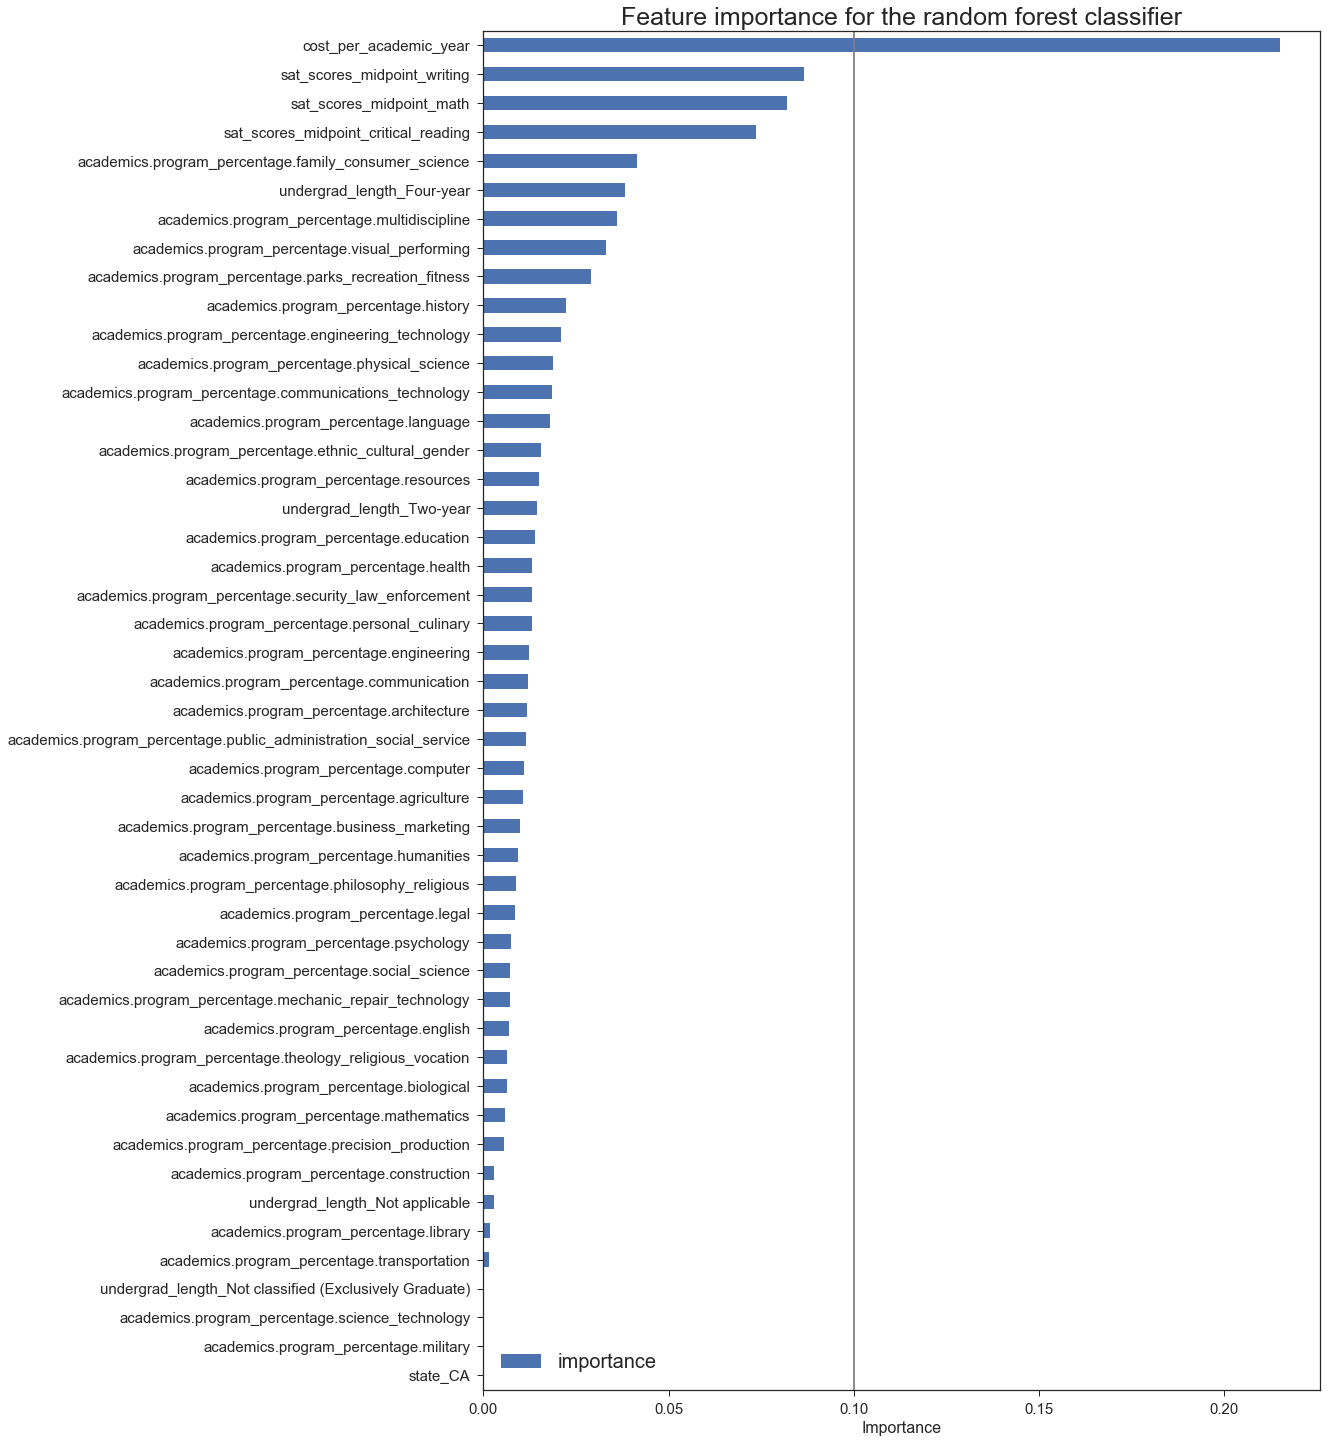

In [97]:
plot_importance(state)